# Tutorial

This tutorial is also a Jupyter notebook, which can be found in [the example notebooks directory](https://github.com/SPIDERCMB/xfaster/tree/main/example/notebooks). If you're running the notebook, rather than looking at the documentation produced from it, the links will not work. [Look at the docs for working links](https://spidercmb.github.io/xfaster/notebooks/XFaster_Tutorial.html).

The notebook reads intermediate output npz files from disk. To instead run the pieces starting from maps, first generate the example maps by running the script `xfaster/example/make_example_maps.py`, and set the checkpoint to something other than `None`.  This script generates sample signal (CMB), noise and foreground ensembles for the two SPIDER frequency bands, as well as two sets of simulated data maps (one with signal, noise and foreground components; and one with just signal and noise components).

## The main ingredients of the XFaster code

Before we get into the functions that produce each of the components that gets fed into the equations for bandpower deviations, $q_b$ and the Fisher matrix (Equations 17 and 18 in the [Algorithm section](../algorithm.rst)), let's first talk about how XFaster is structured and what it expects as inputs.

There are two main python modules in XFaster: [xfaster_exec.py](../api.rst#module-xfaster.xfaster_exec) and [xfaster_class.py](../api.rst#module-xfaster.xfaster_class). [xfaster_exec.py](../api.rst#module-xfaster.xfaster_exec) contains two main functions: [xfaster_run](../api.rst#xfaster.xfaster_exec.xfaster_run) and [xfaster_submit](../api.rst#xfaster.xfaster_exec.xfaster_submit). [xfaster_run](../api.rst#xfaster.xfaster_exec.xfaster_run) calls all of the functions to make XFaster happen (all located in [xfaster_class.py](../api.rst#module-xfaster.xfaster_class)) in the order they need to happen. [xfaster_submit](../api.rst#xfaster.xfaster_exec.xfaster_submit) takes arguments for submitting the job to a queue. XFaster is not highly parallelized. However, significant speed-up is gained from using more cores in the simulation pseudo-spectrum calculation through under-the-hood use of OMP. Therefore, if you're starting from a checkpoint after "sims", no significant speed-up will be gained when using more cores. 

There are a few other modules you might interact with: 

* [parse_tools.py](../api.rst#module-xfaster.parse_tools): contains a bunch of tools for converting between data structures, especially between dictionaries and matrices
* [spec_tools.py](../api.rst#module-xfaster.spec_tools): contains functions for generating and manipulating model power spectra

## Specifying what data to use

The top level module you interact with is [xfaster_exec.py](../api.rst#module-xfaster.xfaster_exec), which takes your arguments, and has some reasonable defaults for any you don't provide. In addition to arguments, you must point the code to the inputs you want to run on. The first of these inputs is maps.

### Maps

The main inputs to the code are maps-- data maps, signal and noise simulations, and masks. Rather than pointing to each map individually, there is a directory structure that the code expects. Its contents look like this:

    <data_root>/
    ├── data_<data_type>
    │   ├── <data_subset1>
    │   │   ├── map_<tag1>.fits
    │   │   ├── ...
    │   │   ├── map_<tagN>.fits
    │   ├── <data_subset2> (same filenames as <data_subset1>)
    │   ├── ....
    │   ├── <data_subsetM>
    ├── signal_<signal_type>
    │   ├── spec_signal_<signal_type>.dat
    │   ├── <data_subset1>
    │   │   ├── map_<tag1>_0000.fits
    │   │   ├── ...
    │   │   ├── map_<tag1>_####.fits
    │   │   ├── ...
    │   │   ├── map_<tagN>_0000.fits
    │   │   ├── ...
    │   │   ├── map_<tagN>_####.fits
    │   ├── ....
    │   ├── <data_subsetM> (same filenames as <data_subset1>)
    ├── noise_<noise_type> (same filenames as signal_<signal_type>)
    ├── masks_<mask_type>
    │   ├── mask_map_<tag1>.fits
    │   ├── ...
    │   ├── mask_map_<tagN>.fits
    [[optional:]]
    ├── foreground_<foreground_type_sim> (same filenames as signal_<signal_type>)
    ├── templates_<template_type>
    │   ├── template1 (same filenames as data_<data_type>)
    │   ├── template2 (same filenames as data_<data_type>)
    └── reference_<reference_type>
        ├── reference1 (same filenames as data_<data_type>)
        └── reference2 (same filenames as data_<data_type>)

Each of `data`, `signal`, `noise`, and `mask` has a top level directory with a preordained, fixed prefix (`data`, `signal`, `noise`, `mask`) and then some suffix specified by the user which is appended with an underscore. So, for example, to run XFaster on the example set of maps, I need to specify in my arguments: `data_type=raw`, `signal_type=synfast`, `noise_type=gaussian`, `mask_type=rectangle`.

All maps must be HEALPIX fits files. Data maps must be named `map_<tag>.fits`; simulated signal and noise maps must be named `map_<tag>_####.fits`, where #### is any length numerical tag indicating a sim realization; and masks are labeled `mask_map_<tag>.fits`.

If using `pol=True`, masks must be 3 x Npix I,Q,U maps. You can use a different mask for intensity and polarization, in which case your mask must be 2 x Npix, where the first row is used for T and the second for P.

To indicate which maps you want, pass the argument `data_subset` a glob-parseable path relative to the top level data directory-- in this case, `data_raw`. [Glob](https://docs.python.org/3/library/glob.html) works just like the unix shell does for matching file paths, so it is easy to test in advance which maps you're going to get. Just do `ls <path_to_data_maps>/full/*150*` and check that all the maps you want to use are listed. Then, you should set `data_subset` to `full/*150*`, for example.

This is all implemented in `_get_data_files()` (called by [get_files()](../api.rst#xfaster.xfaster_class.XFaster.get_files)) like so:
```python


# find all map files                                                               
map_root = os.path.join(data_root, "data_{}".format(data_type))
map_files = []
data_subset = data_subset.split(",")
for f in np.atleast_1d(data_subset):
    files = glob.glob(os.path.join(map_root, "{}.fits".format(f)))
    if not len(files):
        raise OSError("Missing files in data subset {}".format(f))
    map_files.extend(files)
data_subset = ",".join(data_subset)
map_files = sorted(map_files)
map_files = [f for f in map_files if os.path.basename(f).startswith("map_")]
map_tags = [
    os.path.splitext(os.path.basename(f))[0].split("_", 1)[1] for f in map_files
]

```
So you've specified which data maps you want to compute power spectra for. To get the corresponding sim maps, the code takes whatever data maps were found matching data_subset, and tries to match those to maps in the sims directory, with the only difference the sim index tag. Here's what that looks like in the function `_get_sim_files()`:
```python
# find all corresponding sims
# for example, when called for signal sims:
#     _get_sim_files(
#         name="signal",
#         root="signal_{}".format(signal_type),
#         subset=signal_subset,
#     )
root = os.path.join(data_root, root)
num_files = None
all_files = []
for f in map_files:
    files = sorted(
        glob.glob(
            f.replace(map_root, root).replace(
                ".fits", "_{}.fits".format(subset)
            )
        )
    )
    nfiles = len(files)
    if not nfiles:
        raise OSError("Missing {} sims for {}".format(name, f))
    ...
    all_files.append(files)
```

It's easy to get errors at the reading files step. XFaster requires that all your maps have the same number of sims, though you are allowed to have a different from of signal and noise sims. If you do not want to use the full set of signal and noise maps in a directory, if you can set the `signal_subset` and `noise_subset` arguments, which default to `'*'`. This glob-parseable tag is applied to the `####` sim index tag. So, if I have a set of sims, eg, `map_95_0000.fits`-`map_95_0099.fits`, as in the example, but for some reason I only want to use the first 50, I can set `signal_subset='00[0-4]*`.

### Other inputs

In addition to maps, the code also requires a config file. This tells the code everything else it needs to know about your data. Here's the config file for the example:

```python

# Band centers in GHz (needed for foreground fitting) for each map tag.                    
# Tags listed here should be a superset of tags that may be included in a run.             
[frequencies]
95 = 94.7
150 = 151.0

# A numpy dictionary containing Bl for each map tag.                                       
# Keys should match those in freqs.                                                        
# Missing keys should have a fwhm listed below.                                            
# The value for each key should be a numpy array of dimensions (3, lmax + 1),              
# for TT, TP and PP beam windows.                                                          
[beam]
beam_product = None
beam_error_product = None

# FHWM in arcmin for each map tag, if using Gaussian beam model.                           
# Keys should match those in freqs.                                                        
# Missing keys should be in the beam product file.                                         
[fwhm]
95 = 41
150 = 29

# Fractional error on the FWHM for each map tag, if using a Gaussian beam model.           
# Keys should match those in freqs.                                                        
# Missing keys should be in the beam product file.                                         
[fwhm_err]
95 = 0.001
150 = 0.001

# Whether to compute transfer function qb parameters for each map tag.                     
# Keys should match those in freqs.                                                        
[transfer]
95 = true
150 = true
```

This is the full list of options that can be specified in the config file. 

## Step by step through the functions called in xfaster_exec
### Setup and checkpoints

Now we'll proceed to stepping through each function in [xfaster_exec](../api.rst#module-xfaster.xfaster_exec). You'll never run the code this way--you'll just call [xfaster_run](../api.rst#xfaster.xfaster_exec.xfaster_run) or [xfaster_submit](../api.rst#xfaster.xfaster_exec.xfaster_submit) with the arguments that then get passed to these functions. But we'll do it this way so we can illustrate some of the intermediate data products as we go.

This tutorial will follow the example script in [xfaster/example](https://github.com/SPIDERCMB/xfaster/tree/main/example). Note however that becasue maps are not stored in the repository, this notebook is instead reading from the intermediate files written to disk. 

First, we'll import XFaster and initialize our XFaster class with some arguments.

In [1]:
import xfaster as xf
import matplotlib.pyplot as plt
from matplotlib import colors, colormaps
import numpy as np

In [2]:
X = xf.XFaster(config="../../example/config_example.ini", output_root="../../example/outputs_example", verbose="info",
              output_tag="95x150", checkpoint=None)

At the start of an XFaster run, you can specify at what checkpoint to start. The checkpoints are:
```python
checkpoints = [
	"files", # find all the map files
	"masks", # load in masks and compute their pseudo-spectra
	"kernels", # compute mask mode-coupling kernels
	"sims_transfer", # compute pseudo-spectra for signal sims used for computing the transfer function
	"shape_transfer", # load in the model spectrum for the transfer function
	"transfer", # compute the transfer function
	"sims", # compute pseudo-spectra for noise sims and signal sims if they're different from those used for the transfer function
    "beams", # load in the beam window functions, and apply a pixel window function if pixwin=True
    "data", # compute the pseudo-spectra of the data maps
    "template_noise", # compute the pseudo-spectra of template noise simulations, if using Planck dust templates
    "shape", # load in the model spectrum for bandpower computation
	"bandpowers", # do the Fisher iteration to compute bandpowers
	"beam_errors", # start the likelihood over including beam error parameterization
	"likelihood", # compute the parameter likelihoods
]
```

Note that there are options to use different signal simulations for computing the transfer function and for computing other signal terms. This is mainly useful for null tests, as that's the only mode in which signal sims are used for anything other than transfer functions (to compute the expected signal residual that is subtracted from the data pseudo-spectra). If the signal simulations lack sufficient power (eg., for BB), the transfer function may not converge due to lack of measurable power. This is not a problem unique to XFaster, and this option allows the user more flexibility in the choice of sims used for different parts of the algorithm.

Most of the time, `checkpoint` can be set to None, which starts the code from the last checkpoint completed (ie, it successfully wrote its intermediate data to disk). However, if you've made changes to the code or inputs, you may wish to force the code to start from an earlier checkpoint. It will then run that checkpoint and every one after it in the checkpoint tree (given near the top of [the XFaster class](../api.rst#xfaster.xfaster_class.XFaster)).

### get_files

The first function called after initializing the XFaster class is [get_files()](../api.rst#xfaster.xfaster_class.XFaster.get_files). This finds all of the raw data files in the data root that match the data subset criteria and constructs the map dimensions of the estimator.  All other file type arguments (`mask_type`, `signal_type`, `noise_type`, etc) must include files that match the set of map names found here.

In [3]:
file_opts = {
    "data_root": "../../example/maps_example",
    "data_subset": "full/*95,full/*150",
}

In [4]:
file_vars = X.get_files(**file_opts)

In [5]:
file_vars.keys()

dict_keys(['data_root', 'data_subset', 'null_run', 'num_maps', 'map_names', 'map_tags', 'map_pairs', 'map_tags_orig', 'map_pairs_orig', 'map_freqs', 'output_file'])

`file_vars` is a dictionary returned by `get_files` that is also written to disk to finish the checkpoint. For example, all of the files found using your glob-parseable file tags are stored here, so you can see exactly what maps are being used for data:

In [6]:
file_vars['map_names']

array(['full/map_150.fits', 'full/map_95.fits'], dtype='<U17')

### get_bin_def

Now we run [get_bin_def()](../api.rst#xfaster.xfaster_class.XFaster.get_bin_def) set up a dictionary that tells where the edges of the CMB bins are for each spectrum. We can also choose whether to fit for noise residuals or foregrounds, which we can set to have different bin widths than the CMB bins.

In [7]:
bd = X.get_bin_def(bin_width=25, lmin=2, lmax=500, tbeb=True, foreground_fit=False, 
                   residual_fit=True, bin_width_res=100)

In [8]:
bd.keys()

odict_keys(['cmb_tt', 'cmb_ee', 'cmb_bb', 'cmb_te', 'cmb_eb', 'cmb_tb', 'res_eebb_150', 'res_eebb_95'])

In [9]:
bd['cmb_tt']

array([[  2,  27],
       [ 27,  52],
       [ 52,  77],
       [ 77, 102],
       [102, 127],
       [127, 152],
       [152, 177],
       [177, 202],
       [202, 227],
       [227, 252],
       [252, 277],
       [277, 302],
       [302, 327],
       [327, 352],
       [352, 377],
       [377, 402],
       [402, 427],
       [427, 452],
       [452, 477],
       [477, 501]])

This dictionary has a key for each type of spectrum that will be fit, each of which stores the bin edges used for that spectrum fit. Each of these bin edge pairs represents a separate bandpower deviation ($q_b$) that will be fit.

Residuals are fit per map, and by default are fit only for EE and BB, which are constrained to have the same fit parameter. To change this, use the option `res_specs`, which takes a list of the spectra you want to fit residuals for, ie. `["TT", "EE", "BB"]` if you'd like to fit all of the spectra separately.

Another option you might wish to use is `weighted_bins`, which changes the default $\chi_b(\ell)$ binning operator from a tophat to one that weights by $\ell(\ell+1)$.

To enable fitting for a foreground component in the harmonic domain, set `foreground_fit=True`, and use the corresponding `bin_width_fg` to set the bin width for the foreground amplitude bins, and set `lmin_fg` and `lmax_fg` to optionally limit the bandwidth over which foregrounds are to be fit.  Optionally, also set `beta_fit=True` to enable fitting for a frequency spectral index component for the foreground amplitude; otherwise, the frequency dependence is assumed to follow a single component dust model as defined in [scale_dust()](../api.rst#xfaster.spec_tools.scale_dust).  If `foreground_fit` is True, the foreground model is assumed to be a simple power law model, as defined in [dust_model()](../api.rst#xfaster.spec_tools.dust_model), with the same transfer function as the CMB component.

### get_mask_weights

We have now finished all the set-up. Now it's time to start calculating things. First, we compute the cross spectra of our masks--which will be needed for computing the $K_{\ell \ell^{\prime}}$ mode-coupling matrix--and the $g_\ell$ mode-counting factor. This is done with [get_mask_weights()](../api.rst#xfaster.xfaster_class.XFaster.get_mask_weights).

For the example, we will not apply an empirical correction to $g_\ell$, the calibration of which is discussed in Section 2.3.2 of the [XFaster paper](https://arxiv.org/abs/2104.01172).  Otherwise, we would set `apply_gcorr=True`, and the code would look in the masks directory for this correction file for each map. The `reload_gcorr` option is only useful when doing the empirical calibration; it reloads the file, while by-passing the checkpoint tree that is usually performed after `get_mask_weights`.

In [10]:
w_stuff = X.get_mask_weights(mask_type="rectangle", apply_gcorr=False, reload_gcorr=False)

In [11]:
w_stuff.keys()

dict_keys(['wls', 'fsky', 'w1', 'w2', 'w4', 'gmat', 'nside', 'npix', 'gcorr', 'mask_type', 'mask_root', 'mask_files', 'output_file'])

`w1`, `w2`, and `w4` are the first, second, and fourth moments of the mask. `fsky` is the fraction of sky the mask covers. These are needed for computing the $g_\ell$ mode-counting term, labeled `gmat` in the outputs. `gmat` includes the $2\ell+1$ factor and a correction factor, if desired.

`wls`, contains the cross spectra of all the masks. For this and all other pseudo-spectra, the spectrum is computed just as `map2alm`, and then `alm2cl` healpy routines on the maps. If you're doing a polarized spectrum, you'll get three elements, (intensity, pol, intensity x pol). Since our intensity and pol masks are the same, all three elements are the same, and look like this (plotted as $D_\ell$):

Text(0.5, 0, '$\\ell$')

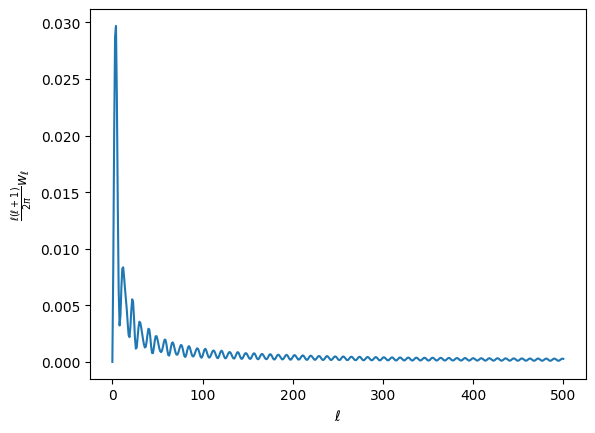

In [12]:
ell = np.arange(501)
lfac = ell * (ell+1) / (2*np.pi)
plt.plot(lfac * w_stuff['wls']['150:150'][0])
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}w_\ell$')
plt.xlabel(r'$\ell$')

**Note:** most of the quantities in XFaster are ordered dictionaries with the following nested structure:
1. Spectra (either plain ['tt', 'ee'], etc, or ['cmb_tt', 'cmb_ee', ..., 'fg_tt', 'fg_ee', ..., 'res_tt', ...]
2. Map/map cross. Crosses are indicated with a colon and are in alphabetical order (so 95 comes after 150, for example): ['150:150', '150:95', '95:95']
3. Stuff. Typically an array, though depending on the data structure, it could be a more deeply nested dictionary.

### get_kernels

The next step is to compute the kernels for each mask auto and cross spectrum using the function [get_kernels()](../api.rst#xfaster.xfaster_class.XFaster.get_kernels).  In the MASTER formalism, the kernel couples modes to each other on the sky due to the finite dimensions of the mask that is applied to each map that goes into computing a cross spectrum.  That is to say, the measured power at a particular $\ell$ is a weighted average over several other neighboring modes $\ell^\prime$, and $K_{\ell\ell^\prime}$ is the matrix that applies this weighting.

The kernels are computed from the power spectrum of the mask, computed in the previous step.

Let's plot some of these up.  Because we are using the same mask for all maps, the kernels for each map pair will look identical.

In [13]:
k = X.get_kernels()
print(k.keys())

dict_keys(['kern', 'pkern', 'mkern', 'xkern', 'window_lmax', 'output_file'])


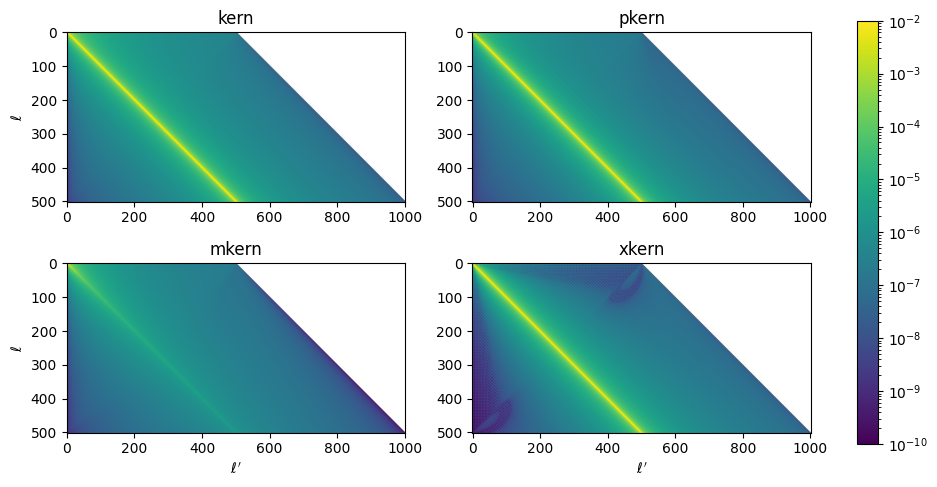

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12,5.5))
m = ax[0,0].imshow(k['kern']['150:150'], norm=colors.LogNorm(vmax=0.01, vmin=1e-10))
ax[0,0].set_title('kern')
ax[0,0].set_ylabel(r'$\ell$')
ax[0,1].imshow(k['pkern']['150:150'], norm=colors.LogNorm(vmax=0.01, vmin=1e-10))
ax[0,1].set_title('pkern')
ax[1,0].imshow(k['mkern']['150:150'], norm=colors.LogNorm(vmax=0.01, vmin=1e-10))
ax[1,0].set_title('mkern')
ax[1,0].set_ylabel(r'$\ell$')
ax[1,0].set_xlabel(r'$\ell^\prime$')
ax[1,1].imshow(np.abs(k['xkern']['150:150']), norm=colors.LogNorm(vmax=0.01, vmin=1e-10))
ax[1,1].set_title('xkern')
ax[1,1].set_xlabel(r'$\ell^\prime$')
fig.colorbar(m, ax=ax.ravel().tolist());

Note that the shorter dimension ($\ell$) of each kernel goes up to $\ell_{max}$, and the longer dimension ($\ell^\prime$) extends to $2 \ell_{max} + 1$.  The kernels are apodized, so that for any row $\ell$, the kernels are zero for values $\ell^\prime > \ell + \ell_{max}$.  The longer dimension is summed over in computing the $\tilde{\mathcal{C}}_{b\ell}$ terms.

### get_masked_sims

Now we want to get the ensemble average of all of our signal and noise simulations, which we're going to use to calculate the filter transfer function and the noise shape, respectively. This is done with [get_masked_sims()](../api.rst#xfaster.xfaster_class.XFaster.get_masked_sims). The method will also compute the signal cross noise terms, which are used for null tests, where they can contribute significantly to the expected residuals that are subtracted from the data.

This function is doing a very simple thing. For each pair of maps of a given sim index, it 

1. Applies the mask.
2. Transforms the maps into $a_{\ell m}$s using the healpy routine `map2alm`.
3. Transforms those into $\tilde{\mathcal{C}}_\ell$s for that pair using the healpy routine `alm2cl`.
4. Adds the $\tilde{\mathcal{C}}_\ell$s to a running average for that particular map cross and spectrum.

It only does `map2alm` once per map and caches the result for use in other cross spectra since this is the slowest step in the function.

In [15]:
sims = X.get_masked_sims(signal_type="synfast", noise_type="gaussian")
print(sims.keys())

dict_keys(['cls_signal', 'cls_sim', 'cls_med', 'cls_noise', 'cls_res', 'signal_type', 'signal_subset', 'signal_root', 'signal_files', 'num_signal', 'noise_type', 'noise_subset', 'noise_root', 'noise_files', 'num_noise', 'output_file'])


The resulting outputs are:

* `cls_signal`: the average of the signal-only cross spectra, used to compute the transfer function
* `cls_noise`: the average of the noise-only cross spectra, used as the noise model, $N_\ell$
* `cls_sim`: the average of the signal+noise spectra, where signal and noise maps are added in $a_{\ell m}$s and thus the spectra include SxN terms.
* `cls_med`: the median of the signal+noise spectra-- this is mainly used for debugging potential biases seen in the pipeline

The rest of the spectra are not symmetrized. For all previously listed spectra, the result is the average of map i x map j and map j x map i, which matters for off-diagonal spectra: TE, TB, EB. Below, we preserve the individual cross spectra as they are needed for the null test model. In this model, at each Fisher iteration, the noise residual fit (per map and per residual spectrum type) is then used to adjust the expectation spectrum subtracted from the data. The expectation spectrum subtracted from, eg, map 1 T x map 2 E is $S_1^T\times S_2^E + S_1^T \times N_2^E + N_1^T \times S_2^E + N_1^T \times N_2^E$. Each of the last three terms is subject to misestimation of $N$, so we account for that by scaling the following terms by the appropriate noise residual fit.

* `cls_res["nxn0"]`: the average spectrum for noise i x noise j
* `cls_res["nxn1"]`: the average spectrum for noise j x noise i
* `cls_res["sxn0"]`: the average spectrum of signal i x noise j
* `cls_res["sxn1"]`: the average spectrum of noise j x signal i
* `cls_res["nxs0"]`: the average spectrum of noise i x signal j
* `cls_res["nxs1"]`: the average spectrum of signal j x noise i


These spectra have all the effects of the masking, filtering, and beam (for signal sims) included. Let's compare a couple of them to get a sense for what they look like.

Text(0.5, 0.98, 'cls_signal')

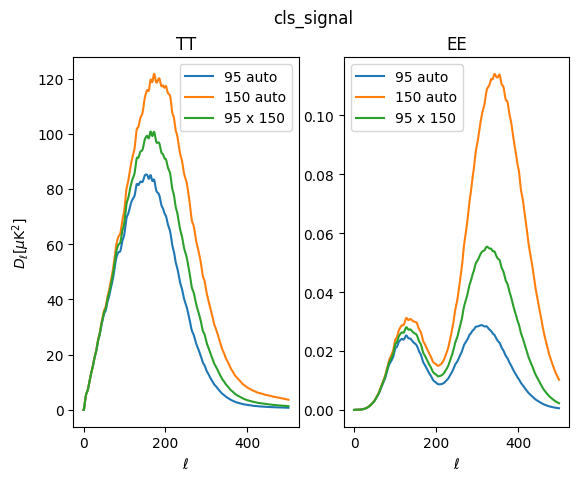

In [16]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(lfac * sims['cls_signal']['tt']['95:95'], label='95 auto')
ax[0].plot(lfac * sims['cls_signal']['tt']['150:150'], label='150 auto')
ax[0].plot(lfac * sims['cls_signal']['tt']['150:95'], label='95 x 150')
ax[0].legend()
ax[0].set_ylabel(r'$D_\ell [\mu \mathrm{K}^2]$')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_title('TT')
ax[1].plot(lfac * sims['cls_signal']['ee']['95:95'], label='95 auto')
ax[1].plot(lfac * sims['cls_signal']['ee']['150:150'], label='150 auto')
ax[1].plot(lfac * sims['cls_signal']['ee']['150:95'], label='95 x 150')
ax[1].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_title('EE')
fig.suptitle('cls_signal')

In this example, we use the same idealized transfer function to make both 95 and 150 GHz maps, so their low-$\ell$ signal is similar. However, for 150 GHz we use a 29 arcmin beam, and for 95 GHz, we use a broader 41 arcmin beam. The difference is evident at high $\ell$, where the 150 GHz signal spectra recover more power.

Similarly, we can plot up the noise averages:

Text(0.5, 0.98, 'cls_noise')

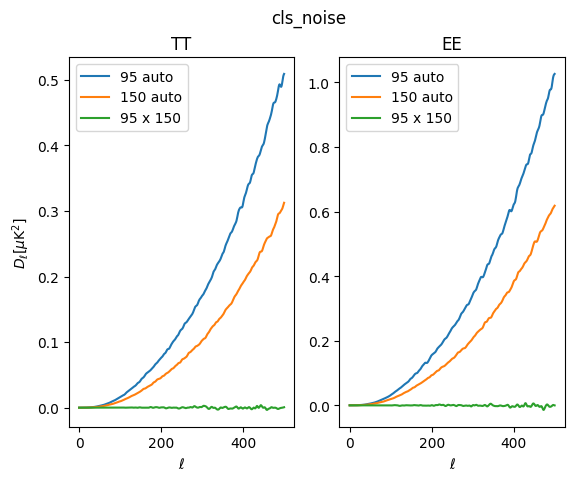

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(lfac * sims['cls_noise']['tt']['95:95'], label='95 auto')
ax[0].plot(lfac * sims['cls_noise']['tt']['150:150'], label='150 auto')
ax[0].plot(lfac * sims['cls_noise']['tt']['150:95'], label='95 x 150')
ax[0].legend()
ax[0].set_ylabel(r'$D_\ell [\mu \mathrm{K}^2]$')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_title('TT')
ax[1].plot(lfac * sims['cls_noise']['ee']['95:95'], label='95 auto')
ax[1].plot(lfac * sims['cls_noise']['ee']['150:150'], label='150 auto')
ax[1].plot(lfac * sims['cls_noise']['ee']['150:95'], label='95 x 150')
ax[1].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_title('EE')
fig.suptitle('cls_noise')

In making the example maps, we have set the noise amplitude to be a bit higher for 95 GHz, which is evident in the noise auto-spectra. As expected, the cross-spectra is uncorrelated and mean-zero.

### get_beams

The next component we need for our equations is the beam window function, $B_\ell$, done with [get_beams()](../api.rst#xfaster.xfaster_class.XFaster.get_beams). XFaster does not solve for this-- you have to tell it what it is. You do this in your config.ini file. You can either specify Gaussian FWHM values (in arcmin) for each map tag, or specify a `.npz` file that contains a dictionary of $B_\ell$ vectors per map tag. You can mix and match these as well-- the code will first look for the tags in the dictionary file, and if it doesn't find the tag there, it will look for a FWHM field for that tag.

The only additional option available is `pixwin`, which is default True. This applies an additional pixel window function to your beam window function, corresponding to the $N_{side}$ of the input maps.

In [18]:
beams = X.get_beams(pixwin=True)
print(beams.keys())

odict_keys(['tt', 'ee', 'bb', 'te', 'eb', 'tb'])


We could have a different beam for intensity and polarization. For this example, we don't, so each of the spectrum fields for beam is the same. Let's plot them for each map.

Text(0.5, 0, '$\\ell$')

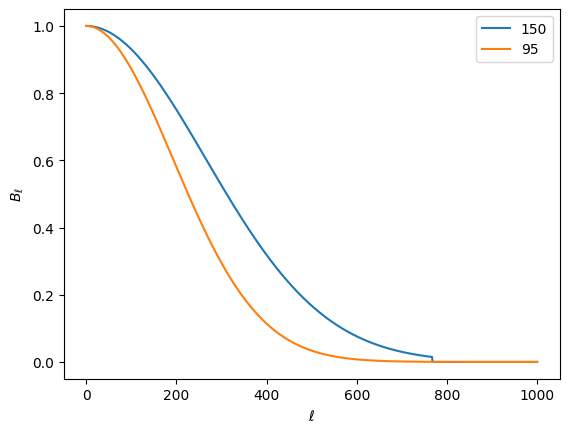

In [19]:
for freq in X.map_tags:
    plt.plot(beams['tt'][freq], label=freq)
plt.legend()
plt.ylabel(r'$B_\ell$')
plt.xlabel(r'$\ell$')

### get_signal_shape

Let's check in on our progress of components we've computed. We're trying to build everything to make up our $\tilde{\mathcal{C}}^{XY}_{b\ell}$s, which as a reminder are the following quantity (for TT):

\begin{equation}
\tilde{\mathcal{C}}^{XY}_{b\ell} = \sum_{\ell^{\prime}} K_{\ell \ell^{\prime}}^{X Y} F_{\ell^{\prime}}^{X Y} B_{\ell^{\prime}}^{2} \mathcal{C}_{\ell^{\prime}}^{X Y (S)} \chi_{b}\left(\ell^{\prime}\right)
\end{equation}

We have $K_{\ell, \ell'}$ and $B_{\ell}$. For the transfer function calculation, we're going to set $F_\ell$ to 1 so that we measure $q_b$s as the deviation from a uniform transfer function for our simulations. Binning, $\chi_b$ has been chosen. All that's left is the full sky signal shape, $\mathcal{C}_{\ell'}^{XY (S)}$, loaded with [get_signal_shape()](../api.rst#xfaster.xfaster_class.XFaster.get_signal_shape). 

For calculating the transfer function, this is just the shape spectrum that went into making our simulations. This spectrum can be specified by setting the [xfaster_run()](../api.rst#xfaster.xfaster_exec.xfaster_run) argument `signal_transfer_spec` to a file containing the spectrum for the signal component. If not provided, the code will look in the maps directory for the signal sims for a file labeled `spec_signal_<signal_type>.dat`. The file is expected to look like a CAMB output file, as demonstrated in `make_example_maps.py`, which writes such a file to the proper location in the signal sims directory.

For foreground fitting, this function also applies a frequency-dependent scaling to the input signal shape, using the [scale_dust()](../api.rst#xfaster.spec_tools.scale_dust) function.  The arguments `freq_ref` and `beta_ref` are used to set the reference frequency and spectral index for the scaling function.

In [20]:
signal_shape = X.get_signal_shape()
print(signal_shape.keys())

odict_keys(['cmb_tt', 'cmb_ee', 'cmb_bb', 'cmb_te', 'cmb_eb', 'cmb_tb'])


These will look familiar to you. Note that they are as long as the long dimension of the $K_{\ell\ell'}$, which is 2$\ell_{max}$ + 1. Also note that EB and TB, expected to be zero, are set to a small flat value.

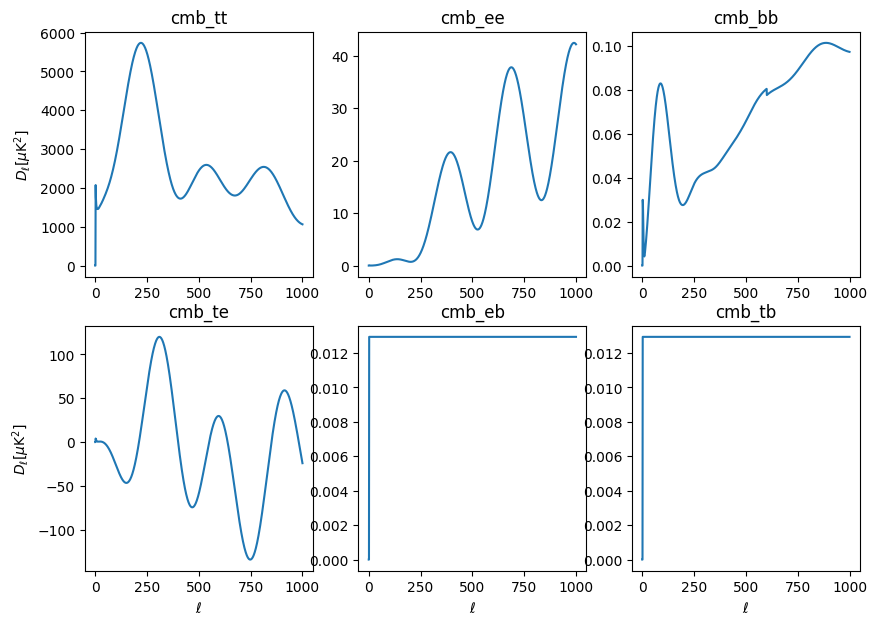

In [21]:
ell2 = np.arange(1001)
lfac2 = ell2 * (ell2 + 1) / (2*np.pi)
fig, ax = plt.subplots(2, 3, figsize=(10,7))
ax = ax.flatten()
for i, (s, spec) in enumerate(signal_shape.items()):
    ax[i].plot(lfac2 * spec)
    ax[i].set_title(s)
    if i in [0,3]:
        ax[i].set_ylabel(r'$D_\ell [\mu\mathrm{K}^2]$')
    if i in [3,4,5]:
        ax[i].set_xlabel(r'$\ell$')

### get_transfer

We now have everything we need to compute the transfer function, which is computed per map per spectrum per CMB bin in [get_transfer()](../api.rst#xfaster.xfaster_class.XFaster.get_transfer). As a refresher, we're trying to get $q_b^{transfer}$, which is the same as our original expression for $q_b$ in [Equation 17 of the Algorithm page](https://spidercmb.github.io/xfaster/algorithm.html#equation-qb), except now we set noise=0, transfer function=1, and instead of using data for our observed signal, we use the ensemble average of our signal sims:

\begin{equation}
q_{b}^{transfer}=\frac{1}{2} \sum_{b^{\prime}} \mathcal{F}_{b b^{\prime}}^{-1} \sum_{\ell} (2 \ell+1) g_\ell^k\left[ \left(\tilde{\mathbf{C}}_{\ell}^{-1} \frac{\partial \tilde{\mathbf{S}}_{\ell}}{\partial q_{b^{\prime}}} \tilde{\mathbf{C}}_{\ell}^{-1}\right)\tilde{\mathbf{C}}_{\ell}^{signal}\right]_{kk}
\label{eq:qb_transfer}
\end{equation}

The expression for the Fisher matrix does not change, other than the fact that its constituents are the same as detailed above for the transfer function.


Within the code, `get_transfer` basically has two steps within the function itself, which it performs per map. 

1. Load up the $\tilde{\mathcal{C}}_{b\ell}$: 
```python 
cbl = self.bin_cl_template(map_tag=m0, transfer=True)
```
This uses the signal_shape internally that we calculated earlier, `m0` is the map, which is used to select the beam and kernel, and `transfer=True` sets the $F_\ell$ term to 1.

2. Run [fisher_iterate()](../api.rst#xfaster.xfaster_class.XFaster.fisher_iterate).
```python
ret = self.fisher_iterate(cbl, m0, transfer=True,
                          iter_max=iter_max, converge_criteria=converge_criteria,
                          save_iters=save_iters, ...)
```

We'll talk more in the `get_bandpowers` section about the details that happen from here, but broadly, XFaster takes all the inputs we've calculated and a starting $q_b$ guess (1 for all bins), computes the Fisher matrix, plugs that into the $q_b$ equation to get a new $q_b$, and repeats. Once the maximum of |(qb_new-qb)/qb| < converge_criteria, it stops iterating and saves the result.

One additional check that `get_transfer` does is to look for transfer function values that are negative. If it finds any, it changes that bin value to the average of the orignal value and the next bin's value. This typically happens due to poor choices of binning or too small a number of signal simulations.

Also, Only TT, EE, BB, and TE transfer functions are calculated. EB and TB are computed as
```python
qb['cmb_eb'] = np.sqrt(np.abs(qb['cmb_ee'] * qb['cmb_bb']))
qb['cmb_tb'] = np.sqrt(np.abs(qb['cmb_tt'] * qb['cmb_bb']))
```

In [22]:
transfer = X.get_transfer()
print(transfer.keys())

odict_keys(['cmb_tt', 'cmb_ee', 'cmb_bb', 'cmb_te', 'cmb_eb', 'cmb_tb'])


Let's look at a couple transfer functions.

(0.0, 1.2)

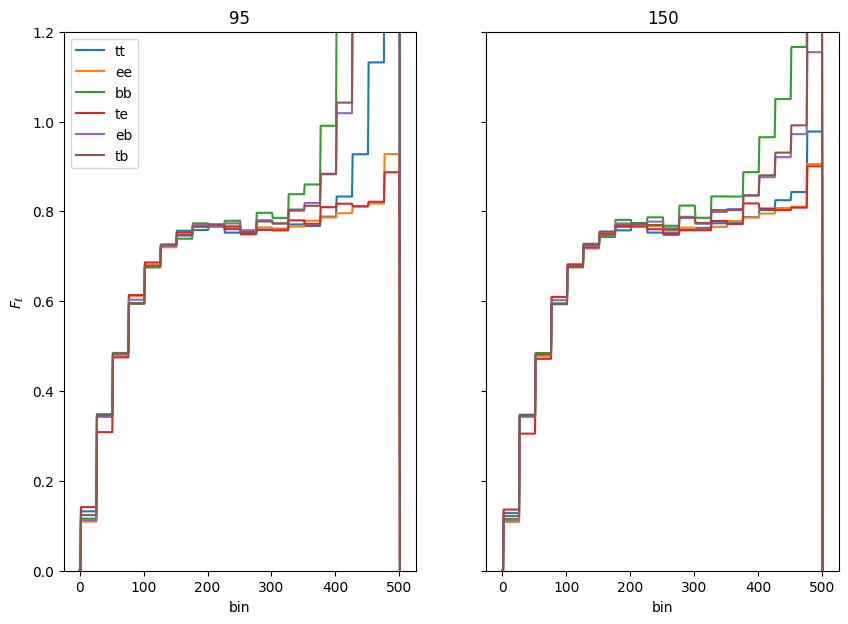

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10,7), sharey=True)
ax = ax.flatten()
plot_inds = {'95': 0, '150': 1}
for s, spec in transfer.items():
    for m, fl in spec.items():
        ax[plot_inds[m]].plot(fl, label=s.split('_')[-1])
        if 'tt' in s:
            ax[plot_inds[m]].set_title(m)
for i in range(2):
    ax[i].set_xlabel('bin')
for i in [0]:
    ax[i].set_ylabel(r'$F_\ell$')
ax[0].legend()
ax[0].set_ylim(0,1.2)

Note that the BB transfer function (and the EB/TB terms computed from it) start to diverge at high multipole. This is due to the lack of signal power in our input spectrum combined with the reduction in power of the beam. For this reason, you might choose to use a model spectrum with more BB power in computing your BB transfer functions.

### get_masked_data

Now comes the step where we compute the data term using [get_masked_data()](../api.rst#xfaster.xfaster_class.XFaster.get_masked_data). This is once again done just by taking all the pseudo-cross-spectra of all the data maps, using `healpy.map2alm` and `healpy.alm2cls`. This is also the step where the cross spectra of foreground templates is performed, if `template_type` is specified.

In [24]:
cls_data = X.get_masked_data(data_type="raw")
print(cls_data.keys())

dict_keys(['cls_data', 'nside', 'data_type', 'map_root', 'map_files', 'output_file'])


Text(0.5, 0.98, 'cls_data')

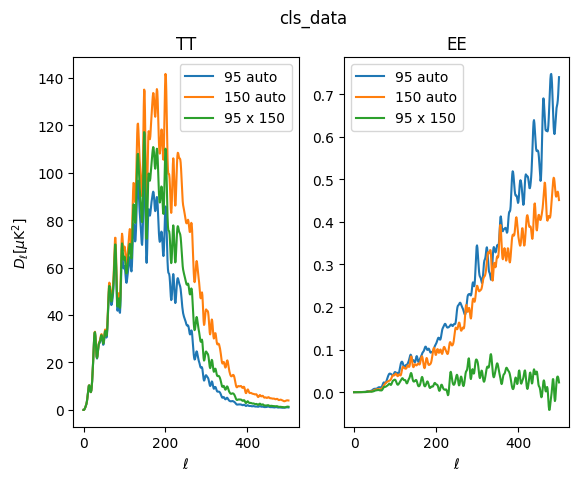

In [25]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(lfac * cls_data['cls_data']['tt']['95:95'], label='95 auto')
ax[0].plot(lfac * cls_data['cls_data']['tt']['150:150'], label='150 auto')
ax[0].plot(lfac * cls_data['cls_data']['tt']['150:95'], label='95 x 150')
ax[0].legend()
ax[0].set_ylabel(r'$D_\ell [\mu \mathrm{K}^2]$')
ax[0].set_xlabel(r'$\ell$')
ax[0].set_title('TT')
ax[1].plot(lfac * cls_data['cls_data']['ee']['95:95'], label='95 auto')
ax[1].plot(lfac * cls_data['cls_data']['ee']['150:150'], label='150 auto')
ax[1].plot(lfac * cls_data['cls_data']['ee']['150:95'], label='95 x 150')
ax[1].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_title('EE')
fig.suptitle('cls_data')

There are several options for manipulating the constructed data before they are passed to the estimator.

* `template_type`, which points to files stored in `templates_<template_type>` for foreground template subtraction
* `template_alpha`: not used for null tests.  This is a dictionary of scalar values, keyed by map tag, to scale foreground templates to be subtracted from the data.  The subtraction is done in alm-space for each tag that is included in the dictionary.
* `reference_type`, which points to files stored in `reference_<reference_type>` for reference signal subtraction for debiasing null tests.  If `reference_type` is set, then some reference signal is subtracted from each half of a null split.  Typically the reference would be something like _Planck_ half-mission datasets, where the _Planck_ instrument noise between the two sets is uncorrelated, such that the cross spectrum of the two reference signals is independent of _Planck_ instrument noise.
* `template_noise_type`, which points to files stored in `templates_noise_<template_noise_type>` for subtracting a correlated noise component from the template terms.  If `template_noise_type` is set, then an ensemble of noise simulations is used to construct an estimate of the instrument noise contribution to the template subtraction and remove it from the data.  Typically this is an ensemble of _Planck_ FFP10 simulations, which by construction introduces a slight correlation in the noise between template halves.  This option accounts for that correlation.
* `template_specs`: A list of spectra for which the template subtraction is applied.  By default, this is done for all spectra that the XFaster estimator is computing.  However, when excluding TT/TE signal from the likelihood, it is necessary to avoid subtracting foreground templates from the TT/TE spectra as well.

Now, computing things for data is typically the final thing you'll be wanting to do. The first way you'll probably run the code is on simulations to make sure things make sense.  The options for doing this are explained below.

### Sim options for get_masked_data

There are several options to [get_masked_data()](../api.rst#xfaster.xfaster_class.XFaster.get_masked_data) that dictate how to build a simulated data set from an ensemble of components on disk.  Note that these options may be passed to this function differently from [xfaster_run()](../api.rst#xfaster.xfaster_exec.xfaster_run).  We'll go through all of them here.

First, there are three options that determine whether any simulated dataset is to be used at all in place of data.  If these are all `False`, then the data maps are loaded from disk as usual.

* `ensemble_mean`: use `cls_sim` in place of the data spectra. This quantity, computed in [the previous sims step](#get_masked_sims) is the average of the signal+noise sims.
* `ensemble_median`: use `cls_med`, the median of the signal+noise sims, in place of the data.
* `sim`: if this option is `True`, the remaining options below are used to determine how the simulated dataset is constructed.  In `xfaster_run`, this option is called `sim_data`.

The following options control the construction of the dataset when `sim=True`.

* `signal_type_sim`/`noise_type_sim`/`foreground_type_sim`/`template_type_sim` -- these are tags corresponding to directories `signal_<signal_type_sim>`, `noise_<noise_type_sim>`, `foreground_<foreground_type_sim>`, `template_<template_type_sim>`. These options are not required to run in `sim_data` mode-- if they are not set, they default to `signal_type_sim=signal_type`, `noise_type_sim=noise_type`, `foreground_type_sim=None` and `template_type_sim=template_type`, as determined in `get_masked_sims()`.
* `components`: A list of components to include in the simulation.  These may include `signal`, `noise`, `foreground` or `template`, and require the appropriate `<component>_type_sim` variable to have been set in `get_files()` above.  In `xfaster_run`, this option is called `sim_data_components`.
* `index`: A dictionary of indices keyed by component name that determine which file from each ensemble to use to construct the data.  For example, `{"signal": 0, "noise": 10}` uses difference sim indices for the signal and noise components.  A `default` key sets the sim index to use for any component not included in the dictionary.  If no default is given, then `0` is assumed.  NB: in the `xfaster_run` function, this dictionary is constructed from the arguments `sim_index_default`, `sim_index_signal`, `sim_index_noise` and `sim_index_foreground`.
* `r`: If this is not `None`, then the `signal` component of the simulated data is constructed from a linear combination of a scalar CMB term and a tensor CMB term, with the latter scaled by the value of `r`.  This option was used for SPIDER to run the ensemble of simulations needed for the Feldman-Cousins analysis, and was written to allow for constructing many different $r$-input maps in memory. For this option to work, the `signal_type_sim` argument must be set to `"r"`, in which case the `get_files()` function searches for an ensemble of scalar sims in the subdirectory `signal_r0` and tensor sims in the subdirectory `signal_r1tens`.  In `xfaster_run`, this option is called `sim_data_r`.
* `qb_file`: If this option is not `None`, then it points to a `bandpowers.npz` file on disk, which contains noise residual bandpowers that can be used to scale the noise component of the simulated data.  In `xfaster_run`, this option is called `qb_file_data`.  NB: a similar option, `qb_file_sim`, can be passed to `get_masked_sims()` to instead apply the residual correction to the noise ensemble that goes into the covariance model (e.g. to test for bias or in single-map mode where fitting for noise residuals doesn't work).
* `template_alpha_sim`: A dictionary similar to `template_alpha` above that handles the _addition_ of foreground templates to the simulated dataset.  In `xfaster_run`, this dictionary is constructed using the arguments `template_alpha_sim` (a list of floats) and `template_alpha_tags_sim` (a list of map tags for each float).
* `save_sim`: If True, the constructed simulation is stored to disk to avoid rebuilding it later.  The filename is constructed as `data_<...>_xcorr.npz` where a set of tags is built from the components that are included in the simulation.  The output `bandpowers.npz` file corresponding to each such simulation includes the same set of tags in the filename.  This file naming scheme allows running multiple simulations in parallel without rerunning intermediate steps or creating IO conflicts on disk.  In `xfaster_run`, this option is called `save_sim_data`.
 
For the example case, we won't use any of these options. They can be super useful for forming expectations for your data outputs, though!

### get_bandpowers

Now we put it all together!  The function [get_bandpowers()](../api.rst#xfaster.xfaster_class.XFaster.get_bandpowers) works just like [get_transfer()](../api.rst#xfaster.xfaster_class.XFaster.get_transfer), with the transfer function terms no longer set to unity, and instead constructed from the $q_b$s computed by [get_transfer()](../api.rst#xfaster.xfaster_class.XFaster.get_transfer).

#### Constructing the model spectrum

The first step is to construct the $\tilde{\mathcal{C}}_{b\ell}$'s including all of the additional components in the model. This is done with [bin_cl_template()](../api.rst#xfaster.xfaster_class.XFaster.bin_cl_template).

In [26]:
cbl = X.bin_cl_template(map_tag=None, transfer=False, use_precalc=False)

Let's plot up each set of components individually.  First, the CMB component, which should look familiar.  Each color represents the $\tilde{\mathcal{C}}_{b\ell}$ for a single bin.  The black lines show the total shape of each component in $\ell$ if the $q_b$ applied to each bin is set to 1 (ie, our signal model is perfectly correct).  This is what we call the *model spectrum* that we are fitting to.  Notice that the EE and BB mixing terms have very broad bins and are very low amplitude.  This is due to the shape of the $_{-}K_{\ell\ell^\prime}$ kernel as a function of $\ell$.  These shapes will look different for each map cross, due to differences in each transfer function and beam.

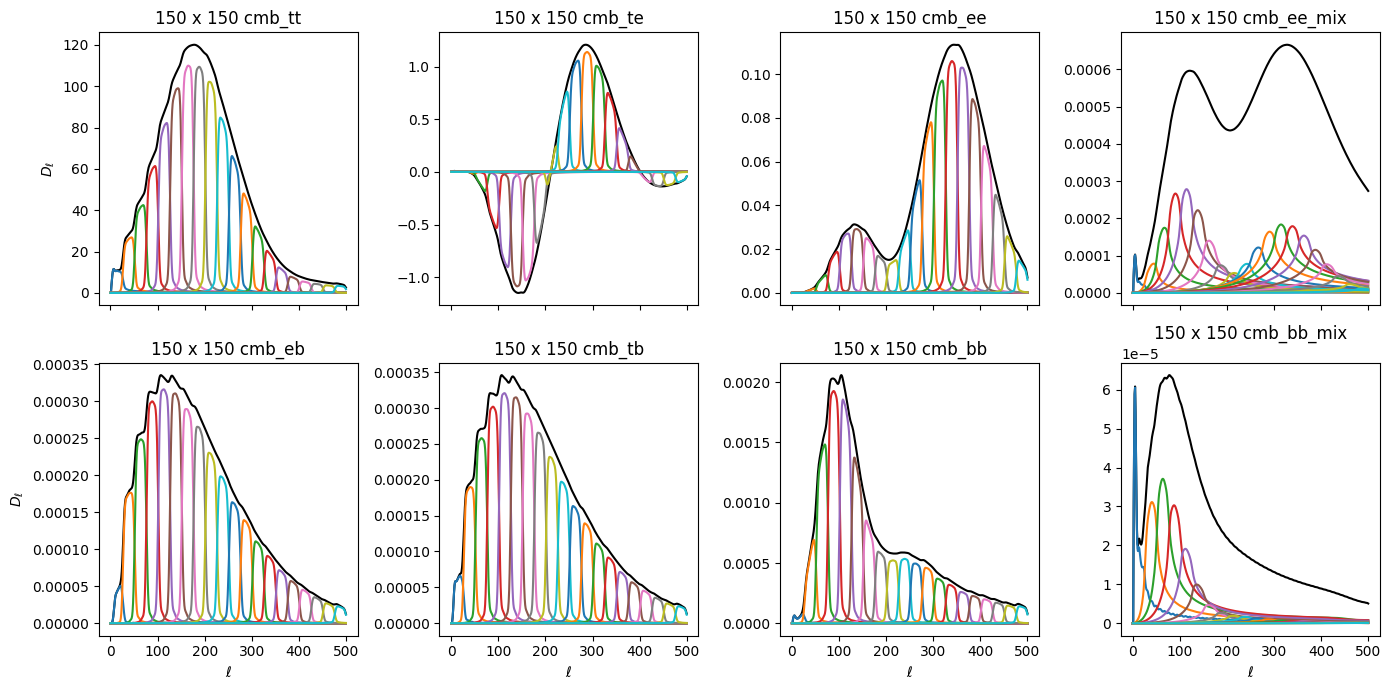

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(14,7), sharex=True)
axs = axs.ravel()
ell = np.arange(501)
ellfac = ell * (ell + 1) / 2.0 / np.pi
comps = ['cmb_tt', 'cmb_te', 'cmb_ee', 'cmb_ee_mix', 'cmb_eb', 'cmb_tb', 'cmb_bb', 'cmb_bb_mix']
for ax, comp in zip(axs, comps):
    ax.set_title('150 x 150 {}'.format(comp))
    cbl1 = cbl[comp]['150:150']
    d = cbl1.sum(axis=0)
    ax.plot(d * ellfac, 'k')
    for d in cbl1:
        ax.plot(d * ellfac)
for i in [0,4]:
    axs[i].set_ylabel(r'$D_\ell$')
for i in range(4,8):
    axs[i].set_xlabel(r'$\ell$')
plt.tight_layout()

The next model component that we include accounts for residual noise in the auto-spectra.  These $\tilde{\mathcal{C}}_{b\ell}$ terms do not include any transfer functions, beams or mode mixing kernels.  They are derived from the *simulated* noise spectra $\tilde{N}_\ell$.  These terms act as corrections to the noise model by adjusting the auto-spectrum noise components to agree with the cross terms.

For the example, we fit only for the EE and BB components, and we require them to be the same.  That is, each $q_b^{res,EEBB}$ applies to both $\tilde{\mathcal{C}}_{b\ell}^{EE}$ and $\tilde{\mathcal{C}}_{b\ell}^{BB}$ here. 

The residual signal model is thus:

\begin{equation}
\tilde{\mathbf{S}}_\ell^{res,ij} = \delta_{ij}\,
\begin{bmatrix}
0 & 0 & 0 \\ 
0 & \sum_b q_b^{EEBB} \tilde{\mathcal{C}}_{b\ell}^{EE} & 0 \\ 
0 & 0 & \sum_b q_b^{EEBB} \tilde{\mathcal{C}}_{b\ell}^{BB} \\ 
\end{bmatrix}_{\,res,ij}
\label{eq:signal_res}
\end{equation}

and the derivatives are

\begin{equation}
\frac{\partial \tilde{\mathbf{S}}_\ell}{\partial q_b^{res,ij,EEBB}} = \delta_{ij}\,
\begin{bmatrix}
0 & 0 & 0 \\ 
0 & \tilde{\mathcal{C}}_{b\ell}^{EE} & 0 \\ 
0 & 0 & \tilde{\mathcal{C}}_{b\ell}^{BB} \\ 
\end{bmatrix}_{\,res,ij}
\label{eq:signal_res_deriv}
\end{equation}

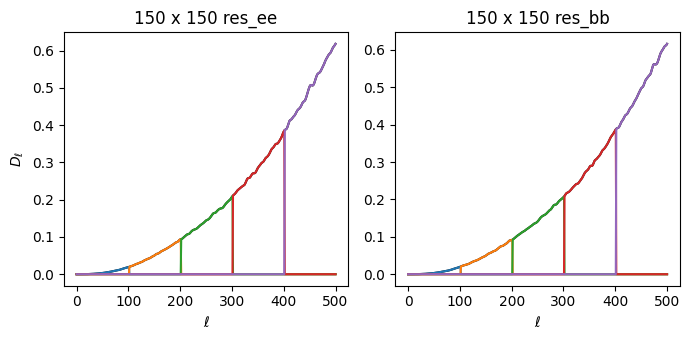

In [28]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(7,3.5))
axs = axs.ravel()
ell = np.arange(501)
ellfac = ell * (ell + 1) / 2.0 / np.pi
comps = ['res_ee', 'res_bb']
for ax, comp in zip(axs, comps):
    ax.set_title('150 x 150 {}'.format(comp))
    cbl1 = cbl[comp]['150:150']
    d = cbl1.sum(axis=0)
    ax.plot(d * ellfac, 'k')
    for d in cbl1:
        ax.plot(d * ellfac)
for i in [0]:
    axs[i].set_ylabel(r'$D_\ell$')
for i in range(2):
    axs[i].set_xlabel(r'$\ell$')
plt.tight_layout()

Next we add our actual noise simulations to the model.  The residual noise terms discussed above are designed to account for inaccuracies in this model. For both the fiducial noise model and the noise residuals, we assume 0 average noise in cross-spectra, and so only add them to the auto-terms of the model.

We often find that the Fisher iterations have trouble converging due to numerical errors that cause the covariance to become singular. To prevent this from happening, we also include a term we call "conditioning noise" along the TT/EE/BB diagonals as well.  The conditioning noise is modeled as constant in $\ell$, where the EE and BB diagonals are set to be `cond_noise` and TT is set to be 10*`cond_noise`. The typical conditioning noise is very small (1e-5 or so), and it is automatically adjusted to be the lowest level possible while still having the algorithm converge. In the final Fisher iteration, the conditioning noise is dropped.

To plot up both of these model components, along with all of the terms discussed above, let's call an internal function that computes the model spectrum for us, given the $\tilde{\mathcal{C}}_{b\ell}$ terms and some model parameters $q_b$: [get_model_spectra()](../api.rst#xfaster.xfaster_class.XFaster.get_model_spectra).

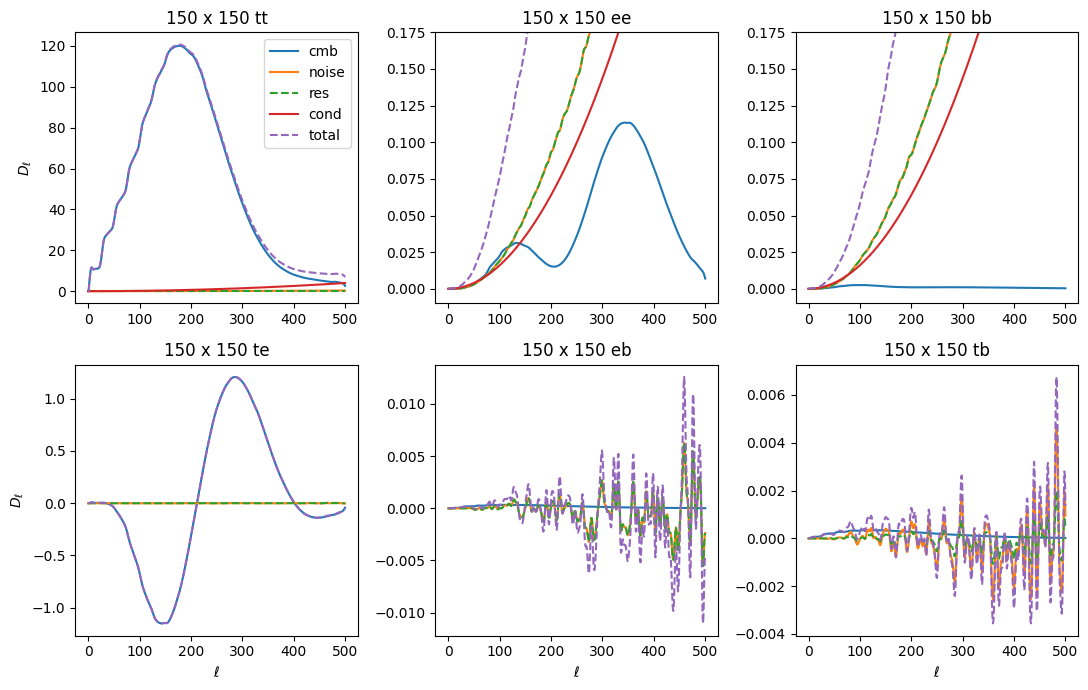

In [29]:
from collections import OrderedDict
# construct a dummy qb array to compute input model
qb = OrderedDict([(k, np.ones(len(v))) for k, v in X.bin_def.items()])
cls_model = X.get_model_spectra(qb, cbl, cls_noise=X.cls_noise, cond_noise=1e-5)

fig, axs = plt.subplots(2, 3, figsize=(11,7))
axs = axs.ravel()
ell = np.arange(501)
ellfac = ell * (ell + 1) / 2.0 / np.pi
xname = '150:150'
for comp in ['cmb', 'noise', 'res', 'cond', 'total']:
    for ax, spec in zip(axs, ['tt', 'ee', 'bb', 'te', 'eb', 'tb']):
        stag = '{}_{}'.format(comp, spec)
        if stag not in cls_model:
            ax.plot(0, 0, label=comp)
            continue
        if comp in ['res', 'total']:
            ax.plot(ellfac * cls_model[stag][xname], label=comp, linestyle='--')
        else:
            ax.plot(ellfac * cls_model[stag][xname], label=comp)
        ax.set_title('150 x 150 {}'.format(spec))
        if spec in ['ee', 'bb']:
            ax.set_ylim(-0.01, 0.175)
axs[0].legend()
for i in [0,3]:
    axs[i].set_ylabel(r'$D_\ell$')
for i in range(3,6):
    axs[i].set_xlabel(r'$\ell$')
plt.tight_layout()

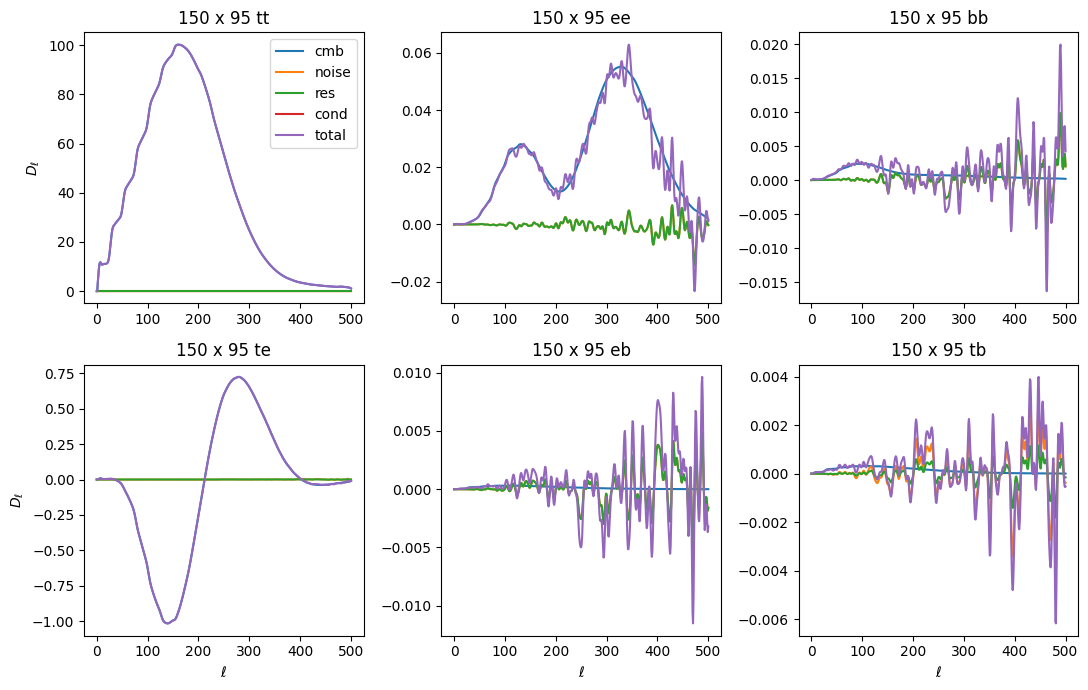

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(11,7))
axs = axs.ravel()
ell = np.arange(501)
ellfac = ell * (ell + 1) / 2.0 / np.pi
xname = '150:95'
for comp in ['cmb', 'noise', 'res', 'cond', 'total']:
    for ax, spec in zip(axs, ['tt', 'ee', 'bb', 'te', 'eb', 'tb']):
        stag = '{}_{}'.format(comp, spec)
        if stag not in cls_model or xname not in cls_model[stag]:
            ax.plot(0, 0, label=comp)
            continue
        ax.plot(ellfac * cls_model[stag][xname], label=comp)
        ax.set_title('150 x 95 {}'.format(spec))
axs[0].legend()
for i in [0,3]:
    axs[i].set_ylabel(r'$D_\ell$')
for i in range(3,6):
    axs[i].set_xlabel(r'$\ell$')
plt.tight_layout()

Note that neither conditioning noise nor residual terms are present in the cross-spectra.

#### Computing the Fisher matrix

Ok! Now that we have all the pieces in place, all that's left is to do some matrix math and iterate over the equations for [q_b](https://spidercmb.github.io/xfaster/algorithm.html#equation-qb) and the [Fisher matrix](https://spidercmb.github.io/xfaster/algorithm.html#equation-qb) until the results converge.  The two equations are constructed in the function [fisher_calc()](../api.rst#xfaster.xfaster_class.XFaster.fisher_calc), which is called iteratively by [fisher_iterate()](../api.rst#xfaster.xfaster_class.XFaster.fisher_iterate) until convergence is reached.

In order to make all the quantities we've computed look like matrices, we have two utility functions, [dict_to_dmat()](../api.rst#xfaster.parse_tools.dict_to_dmat) and [dict_to_dsdqb_mat()](../api.rst#xfaster.parse_tools.dict_to_dsdqb_mat), that convert the dictionaries `Dmat1` (corresponding to $\mathbf{\tilde{C}}_\ell$ in the equations) and `dSdqb_mat1_freq` ($\partial \mathbf{\tilde{S}}_\ell / \partial q_b$) into matrices.

The `Dmat1` matrix has shape `(3 * num_maps, 3 * num_maps, lmax + 1)` and contains the `total` model terms for each map cross spectrum, ordered as [shown here](https://spidercmb.github.io/xfaster/algorithm.html#equation-dell).  The `dSdqb_mat1_freq` matrix has shape `(3 * num_maps, 3 * num_maps, nbins, lmax + 1)` and includes the CMB, residuals and frequency-corrected foreground components for all the crosses. We then compute the quantity

\begin{equation}
\mathbf{\tilde{C}}^{-1} \frac{\partial \mathbf{\tilde{S}}}{\partial q_b} \mathbf{\tilde{C}}^{-1}
\end{equation}

using the following code:

```python
Dinv = np.linalg.inv(Dmat1.swapaxes(0, -1)).swapaxes(0, -1)
eye = np.eye(len(gmat))
mat1 = np.einsum('ij...,jk...->ik...', eye, Dinv)
mat2 = np.einsum('klm...,ln...->knm...', dSdqb_mat1_freq, Dinv)
mat = np.einsum('ik...,knm...->inm...', mat1, mat2)
```

The first line computes the inverse of $D$, ell-by-ell along the first two dimensions.  The next two lines are necessary due to some quirk of memory access in python; this is just multiplying the first two dimensions of `Dmat1` by the identity matrix.  The last two lines do the matrix multiplication along the first two dimensions of each of the matrices.

Now, we apply the $\mathbf{g}_\ell$ mode-counting factor, and at the same time take the trace and sum over ell, computing everything needed for $q_b$ except $\Sigma_b \mathcal{F}_{b b^{\prime}}$:
```python
qb_vec = np.einsum("iil,ijkl,jil->k", gmat, mat, Dmat_obs) / 2.0
```
The Fisher matrix is:
```python
fisher = np.einsum("iil,ijkl,jiml->km", gmat, mat, dSdqb_mat1_freq) / 2
```

Finally, we get our updated estimate of $q_b$ and its covaraince, the inverse Fisher matrix, and then convert the former array into a readable dictionary:
```python
qb_vec = np.linalg.solve(fisher, qb_vec)
inv_fish = np.linalg.solve(fisher, np.eye(len(qb_vec)))
qb_vec = pt.arr_to_dict(qb_vec, qb)
```

With each iteration, we compare the new `qb_vec` quantity to the previous one, until the maximum fractional change in any element of the array is less than the convergence criterion (0.005 is typical).

#### Constructing final bandpowers

To construct bandpowers, we need to convert the $q_b$ parameters to spectrum bandpowers. The function that handles this is [do_qb2cb()](../api.rst#xfaster.xfaster_class.XFaster.do_qb2cb) This is done by first constructing window functions for each $q_b$ parameter (using [fisher_calc()](../api.rst#xfaster.xfaster_class.XFaster.fisher_calc) with the option `windows=True`), then using that to build a matrix that rotates $q_b$ into bandpowers.  For this example, the quantity we want in the end should be in units of $\mathcal{D}_\ell = \ell (\ell + 1) C_\ell / 2\pi$. You can also return bandpowers in units of $C_\ell$ using `return_cls=True`, which will change the rotation matrix.  Explicitly, we have for the $\mathcal{D}_b$ bandpowers:

\begin{equation}
\mathcal{D}^{XY}_b = \sum_B q^{XY}_B \frac{\partial\langle \mathcal{D}^{XY}_b\rangle}{\partial q^{XY}_B} =
\sum_B q^{XY}_B \frac{\sum_\ell \mathcal{N}_\ell W^{XY(q)}_{b\ell} \chi^{XY}_{B \ell} \mathcal{D}^{XY(S)}_\ell} {\sum_\ell \mathcal{N}_\ell W^{XY(q)}_{b\ell} }\,,
\end{equation}

where the normalization function is

\begin{equation}
\mathcal{N}_\ell = \frac{1}{2}\frac{(2\ell + 1)}{\ell (\ell + 1)}\,,
\end{equation}

and the matrix of derivatives is block-diagonal in the spectrum component $XY$. Similarly, the errors on each bandpower are:

\begin{equation}
\Delta\mathcal{D}_b = \left[\sum_{BB^\prime} \mathcal{F}^{-1}_{BB^\prime} \frac{\partial\langle \mathcal{D}_b\rangle}{\partial q_B} \frac{\partial\langle \mathcal{D}_{b}\rangle}{\partial q_{B^\prime}}\right]^{1/2}\,,
\end{equation}

and the window functions for each $\mathcal{D}_b$ are:

\begin{equation}
W_{b\ell}^{XY(\mathcal{D})} = \sum_B W_{B\ell}^{XY(q)} \frac{\partial\langle \mathcal{D}^{XY}_b\rangle}{\partial q^{XY}_B} \,,
\end{equation}

with normalization $\sum_\ell \mathcal{N}_\ell W_{b\ell}^{(\mathcal{D})} = 1$.  The bandpowers, errors, $q_b$ window functions and bandpower window functions are all stored in the bandpowers output file.  More details on the bandpower window functions can be found in Section 2.5 of the [XFaster paper](https://arxiv.org/abs/2104.01172).

#### Looking at results

Now we'll just run the function that wraps up all these internal functions, [get_bandpowers()](../api.rst#xfaster.xfaster_class.XFaster.get_bandpowers).

In [31]:
bp = X.get_bandpowers(converge_criteria=0.005, iter_max=200, save_iters=True, cond_noise=1e-5, cond_criteria=5e3)

In the plot below, we'll plot up the maximum fractional change in $q_b$ with iteration. This information is printed in the logs, but it's helpful to visualize on a plot. You can see it bounce around early on before settling down and ultimately stopping once it gets to the desginated criterion.

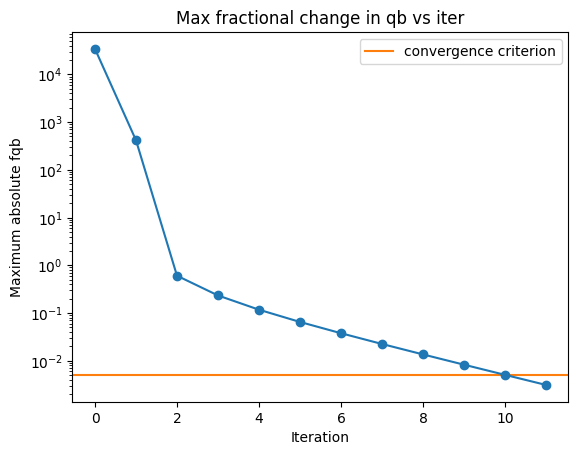

In [32]:
import glob
iters = sorted(glob.glob('../../example/outputs_example/95x150/bandpowers_iter*'))
### Figure for seeing how convergence looks in fqb
fig_fqb, ax_fqb = plt.subplots()
ax_fqb.axhline(0.005, label='convergence criterion', color='C1')
ax_fqb.set_title('Max fractional change in qb vs iter')
ax_fqb.set_ylabel('Maximum absolute fqb')
ax_fqb.set_xlabel('Iteration')
fqb = np.zeros(len(iters))
for i, bp0 in enumerate(iters):
    b = xf.load_and_parse(bp0)
    fqb[i] = np.max(np.abs(b['fqb']))
ax_fqb.plot(fqb, marker='o')
ax_fqb.legend()
ax_fqb.set_yscale('log')

Now let's see how the total model (summing up the $q_b\mathcal{C}_{b\ell}$ terms for every component) to see how it converges to fit the data. Within a few iterations, it's quite close.

/tmp/ipykernel_2886/3330377454.py:23: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 1 Axes> than <Figure size 1500x1000 with 7 Axes> which fig.colorbar is called on.
  fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(),


Text(0.5, 0.98, '95$\\times$150 GHz total power fit')

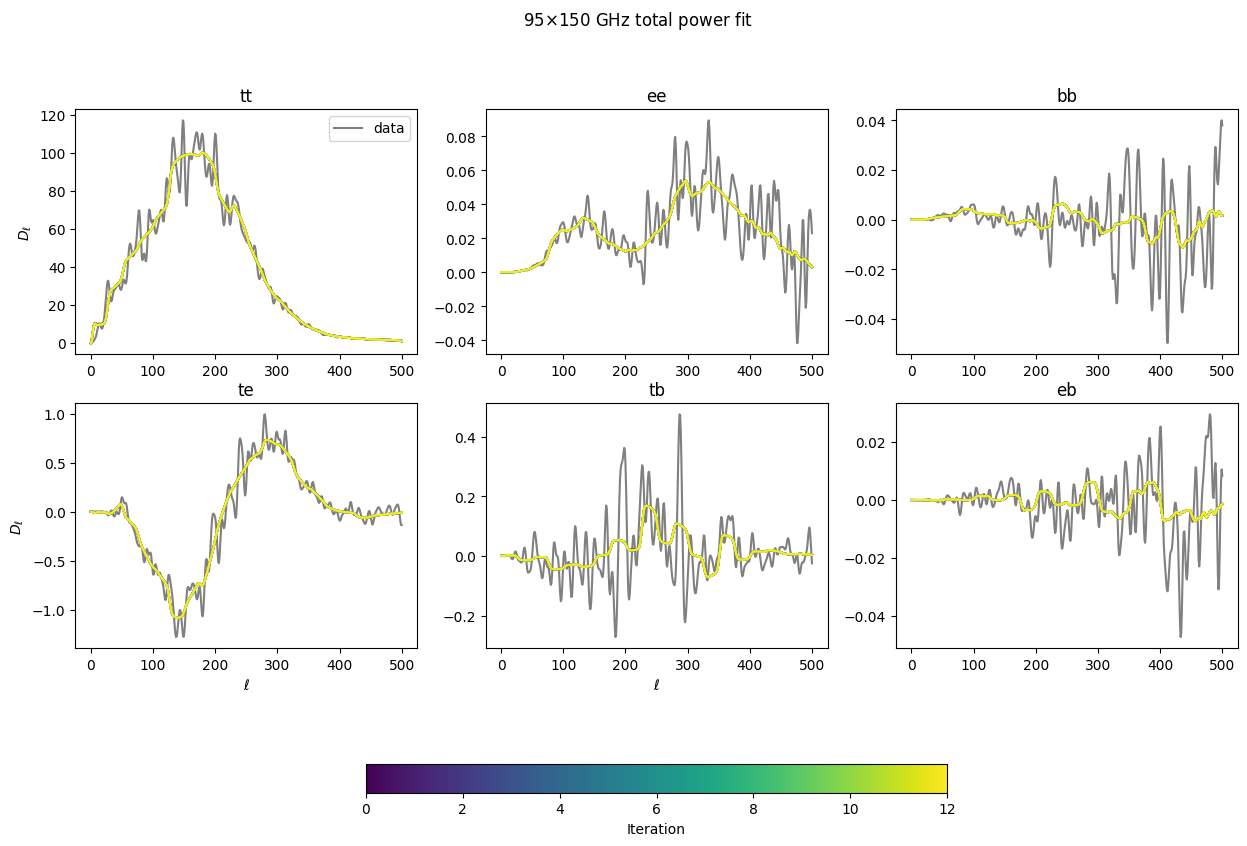

In [33]:
### Figure for looking at how sum(qbCbl) changes with iteration to match data
figtmp = plt.figure()
tmpplot = plt.imshow(np.zeros((2,2)), cmap='viridis',vmin=0, vmax=len(iters))
plt.close(figtmp)
fig_dat, ax_dat = plt.subplots(2,3, figsize=(15,10))
ax_dat = ax_dat.flatten()
specs = ['tt', 'ee', 'bb', 'te', 'tb', 'eb']
colors = colormaps['viridis'].resampled(len(iters)).colors
for s, spec in enumerate(specs):
    ax_dat[s].set_title(spec)
for i, bp0 in enumerate(iters):
    b = xf.load_and_parse(bp0)
    for s, spec in enumerate(specs):
        if i == 0:
            # data cls don't change with iter- plot once.
            ax_dat[s].plot(b['cls_obs'][spec]['150:95'] * lfac, color='gray', label='data')
        ax_dat[s].plot(b['cls_model']['total_'+spec]['150:95'] * lfac, color=colors[i])
for i in [0, 3]:
    ax_dat[i].set_ylabel(r'$D_\ell$')
for i in range(3,5):
    ax_dat[i].set_xlabel(r'$\ell$')
ax_dat[0].legend()
fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(), 
                 orientation='horizontal', shrink=0.5)

fig_dat.suptitle(r'95$\times$150 GHz total power fit')

Now let's look at just the $q_b$ values for each of the different component and see how they converge as a function of iteration and bin. The lowest bins tend to have the biggest moves, but for all components, everything gets close to its final value within a handful of iterations.

/tmp/ipykernel_2886/2057615218.py:26: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 1 Axes> than <Figure size 2000x1500 with 7 Axes> which fig.colorbar is called on.
  fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(),


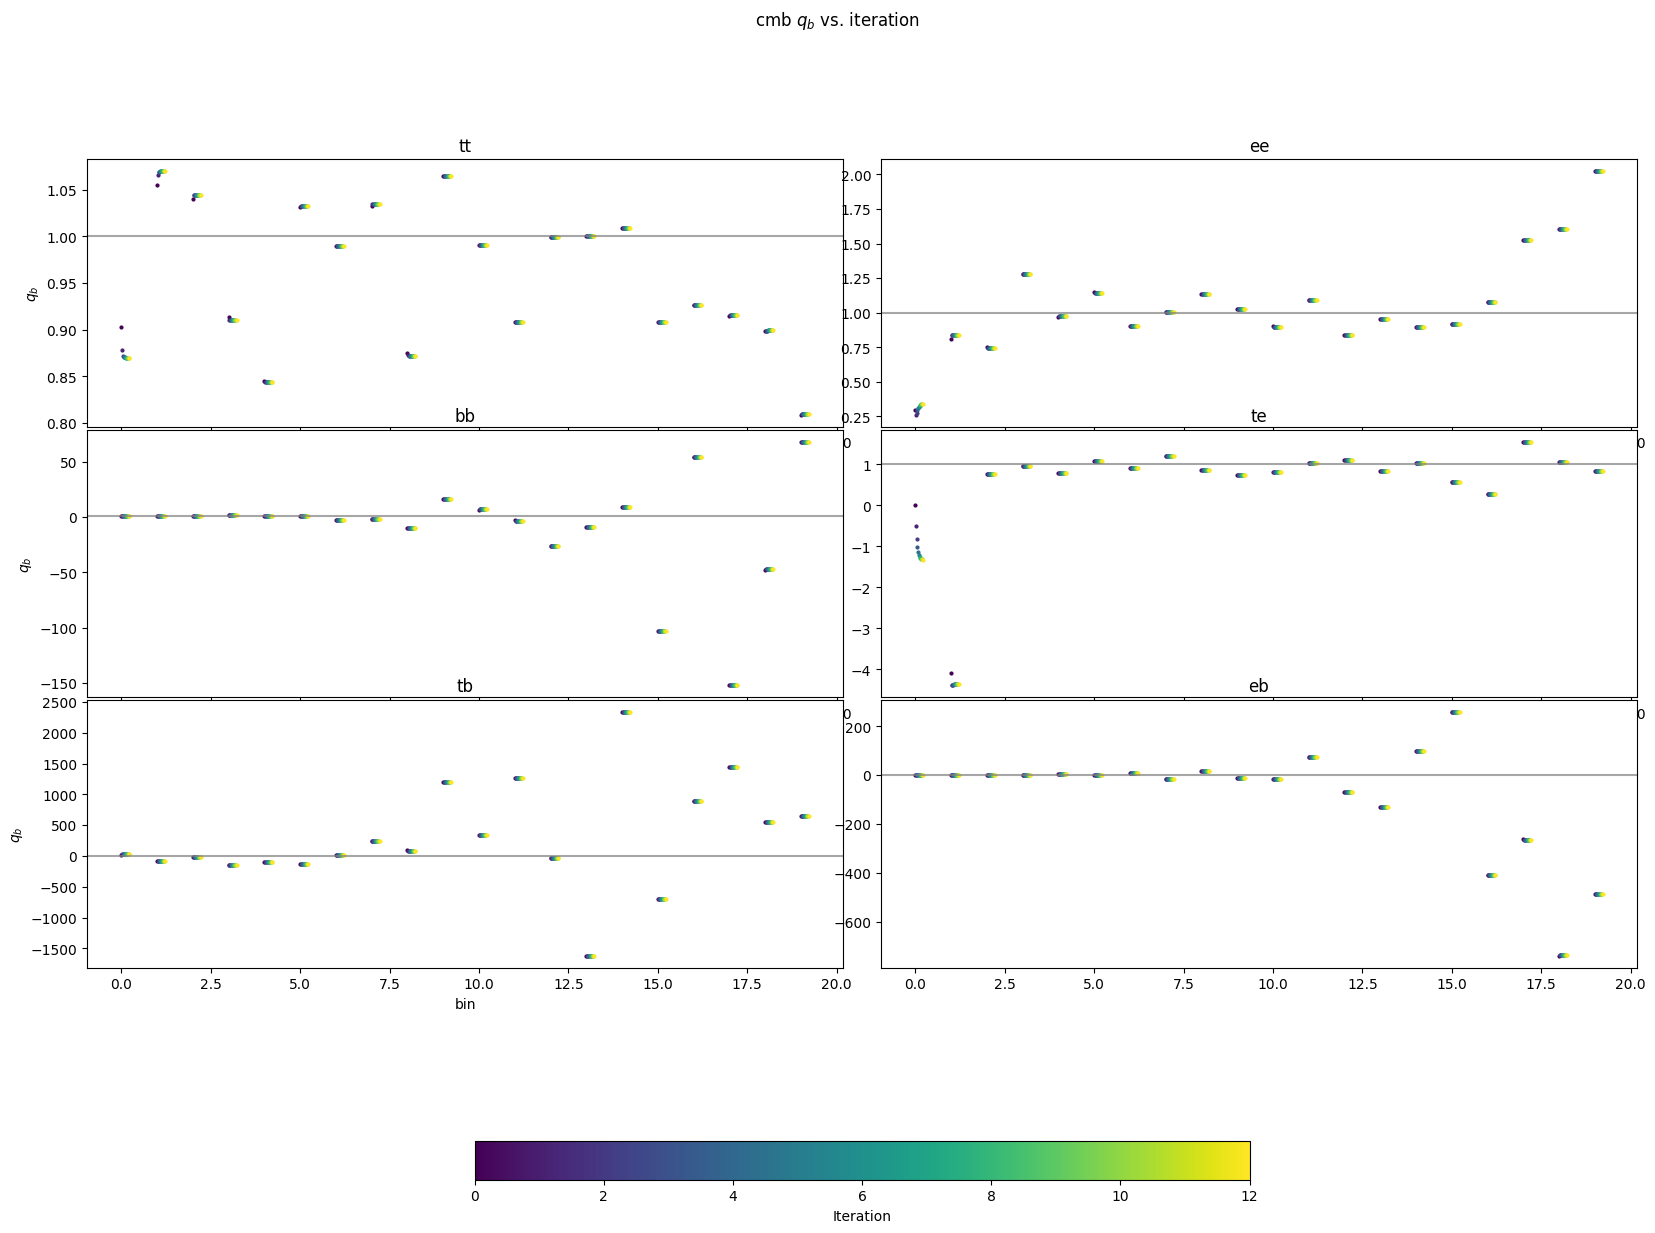

In [34]:
### Figure for looking at how qb for each bandpower changes with iteration
figtmp = plt.figure()
tmpplot = plt.imshow(np.zeros((2,2)), cmap='viridis',vmin=0, vmax=len(iters))
plt.close(figtmp)
specs = ['tt', 'ee', 'bb', 'te', 'tb', 'eb']
colors = colormaps['viridis'].resampled(len(iters)).colors
scatter = 1. / 50.
for comp in ['cmb']:
    fig_dat, ax_dat = plt.subplots(3,2, figsize=(20,15))
    fig_dat.suptitle(comp+r' $q_b$ vs. iteration')
    ax_dat = ax_dat.flatten()
    for s, spec in enumerate(specs):
        ax_dat[s].set_title(spec)
        ax_dat[s].axhline(1, color='gray', alpha=0.7)
    for i, bp0 in enumerate(iters):
        b = xf.load_and_parse(bp0)
        for s, spec in enumerate(specs):
            ax_dat[s].scatter(np.arange(20) + scatter * i, 
                              b['qb'][comp+'_'+spec], color=colors[i], s=4)
    for i in [0, 2, 4]:
        ax_dat[i].set_ylabel(r'$q_b$')
    for i in range(4,5):
        ax_dat[i].set_xlabel('bin')

    plt.subplots_adjust(wspace=0.05, hspace=0.01)
    fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(), 
                     orientation='horizontal', shrink=0.5)


Now we'll look at the noise residuals that were fit. In the script where we make the example maps, we made the "data" maps have 15% less noise in them than the those used for the noise model. So, we should expect the total noise, $(1+n_b)\left<N\right>$, to be $0.85^2\left<N\right>$, where the square comes because we're fitting in the power spectrum. So, $n_b$s should converge to about -0.28. 

/tmp/ipykernel_2886/1064113871.py:21: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 1 Axes> than <Figure size 1000x800 with 3 Axes> which fig.colorbar is called on.
  fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(),


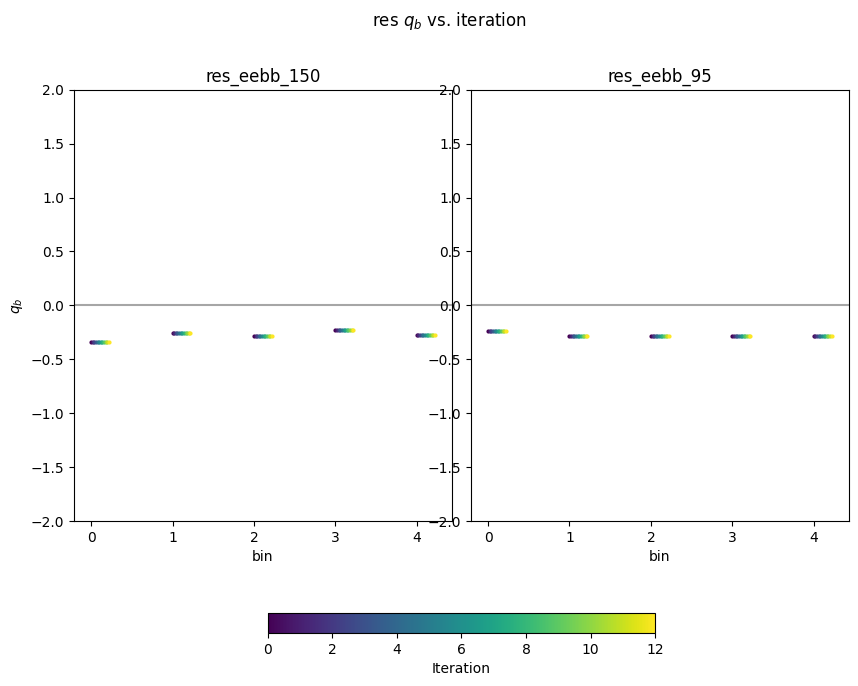

In [35]:
# Now plot residuals
fig_dat, ax_dat = plt.subplots(1,2, figsize=(10,8))
fig_dat.suptitle(r'res $q_b$ vs. iteration')
ax_dat = ax_dat.flatten()
maps = [x for x in bp['qb'] if 'res' in x]
for s, m0 in enumerate(maps):
    ax_dat[s].set_title(m0)
    ax_dat[s].axhline(0, color='gray', alpha=0.7)
    ax_dat[s].set_ylim(-2,2)
for i, bp0 in enumerate(iters):
    b = xf.load_and_parse(bp0)
    for s, m0 in enumerate(maps):
        ax_dat[s].scatter(np.arange(5) + scatter * i, 
                          b['qb'][m0], color=colors[i], s=4)
for i in [0]:
    ax_dat[i].set_ylabel(r'$q_b$')
for i in range(2):
    ax_dat[i].set_xlabel('bin')

plt.subplots_adjust(wspace=0.05, hspace=0.01)
fig_dat.colorbar(tmpplot, label='Iteration', ax=ax_dat.ravel().tolist(), 
                 orientation='horizontal', shrink=0.5)

Now that everything has converged, let's plot up what the final bandpowers and error bars look like. XFaster saves the binned bandpowers as $D_\ell$s by default, though they are labeled `cb`. The error bars are in `dcb`, and those are also computed without sample variance in `dcb_nosampvar`. Covariance is in `cov`, and it also has a no sample variance version, `cov_nosampvar`.

To calculate error bars and covariances without sample variance, XFaster just does one final calculation of the Fisher matrix (after everything has converged), with all the $q_b$s set to a very small number, thereby nulling out the signal. The error bars and covariance without sample variance come from that Fisher matrix.

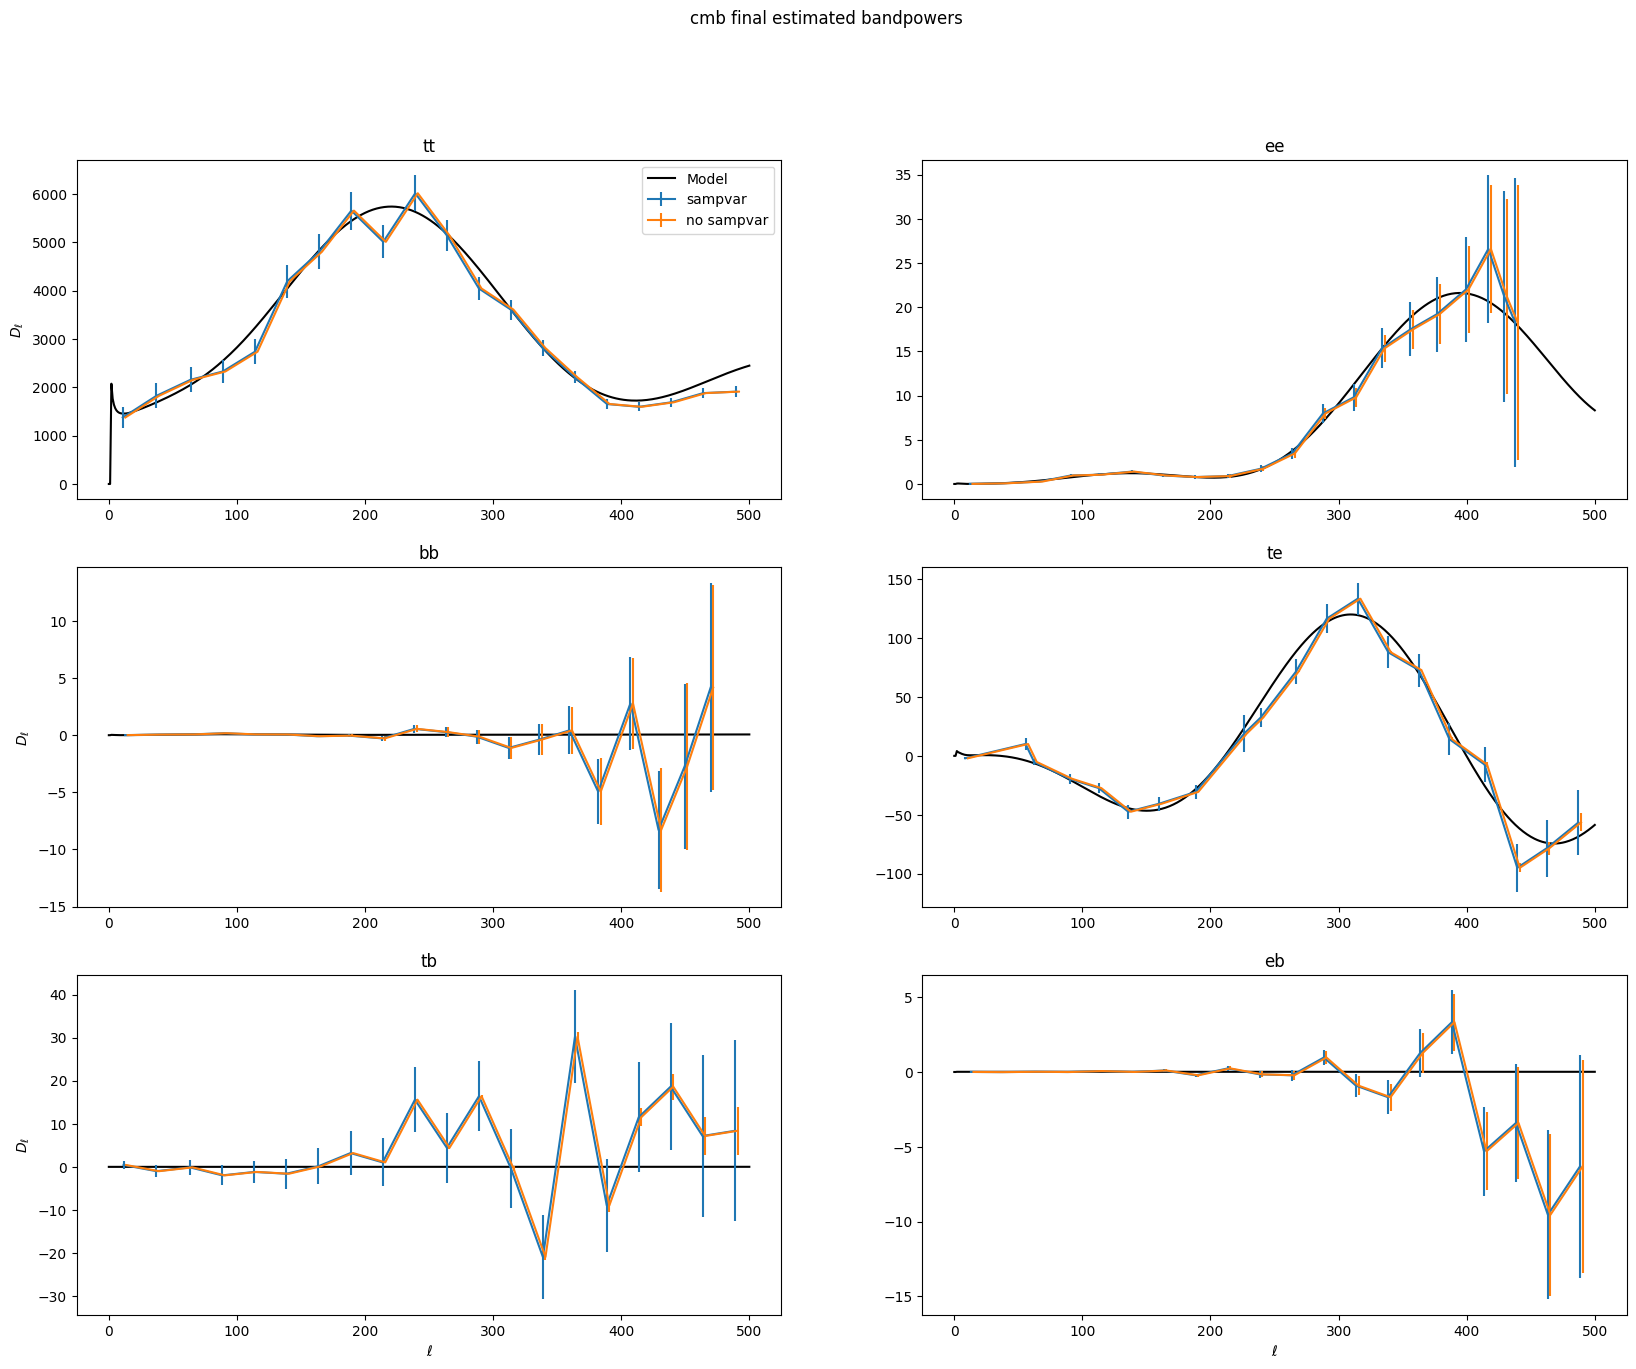

In [36]:
for comp in ['cmb']:
    fig, ax = plt.subplots(3,2, figsize=(20,15))
    ax = ax.flatten()
    fig.suptitle('{} final estimated bandpowers'.format(comp))
    for s, spec in enumerate(specs):
        sn = '{}_{}'.format(comp, spec)
        ax[s].set_title(spec)
        ax[s].plot(lfac * signal_shape[sn][:501], 'k-', label='Model')     
        ax[s].errorbar(bp['ellb'][sn], bp['cb'][sn], bp['dcb'][sn], label='sampvar') 
        ax[s].errorbar(bp['ellb'][sn]+2, bp['cb'][sn], bp['dcb_nosampvar'][sn], label='no sampvar')
    ax[0].legend()
    for i in [0, 2, 4]:
        ax[i].set_ylabel(r'$D_\ell$')
    for i in [4,5]:
        ax[i].set_xlabel(r'$\ell$')

The error bars are just the diagonal of the covariance matrix. Let's look at the covariance matrix with and without sample variance.

/tmp/ipykernel_2886/2035294658.py:8: UserWarning: Adding colorbar to a different Figure <Figure size 1500x1000 with 3 Axes> than <Figure size 1000x800 with 3 Axes> which fig.colorbar is called on.
  fig_dat.colorbar(p, label='Covariance', ax=ax.ravel().tolist(),


Text(0.5, 1.0, 'Without sample variance')

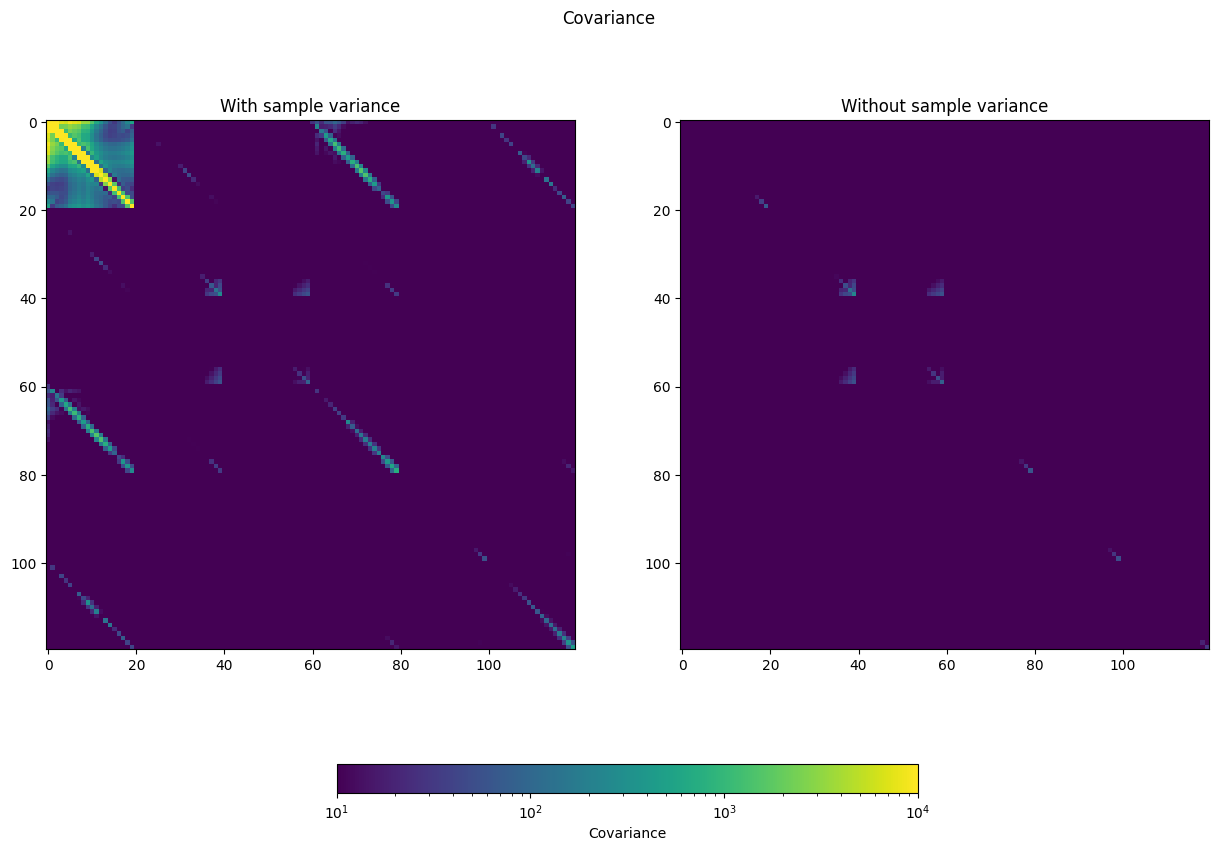

In [37]:
from matplotlib.colors import LogNorm
norm = LogNorm(vmin=10, vmax=1e4)
fig, ax = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Covariance')
p = ax[0].imshow(np.abs(bp['cov']), norm=norm)
ax[0].set_title('With sample variance')
ax[1].imshow(np.abs(bp['cov_nosampvar']), norm=norm)
fig_dat.colorbar(p, label='Covariance', ax=ax.ravel().tolist(), 
                 orientation='horizontal', shrink=0.5)
ax[1].set_title('Without sample variance')

This is a 120 x 120 bin matrix, with each of the 20 CMB bins for each spectrum in order (TT, EE, BB, TE, EB, TB).

### get_likelihood

Now we can compute parameter likelihoods with [get_likelihood()](../api.rst#xfaster.xfaster_class.XFaster.get_likelihood). All of the things we've constructed so far are used, except instead of parameterizing the model with $q_b$ bandpower deviations, we set those to 1, and then make the model a function of cosmological parameters. For the example, we will just use $r$ as our parameter. We then compute the likelihood for the data for each step in a Monte Carlo sampler, where we just vary $r$. For this example, since we're only varying one paramter, we'll do a brute force search: 

In [38]:
loglike = X.get_likelihood(qb=bp['qb'], inv_fish=bp['inv_fish'], mcmc=False)

[ 2025-04-08 20:04:09UTC ] INFO: Computing brute-force r profile likelihood


Text(0.5, 0, '$r$')

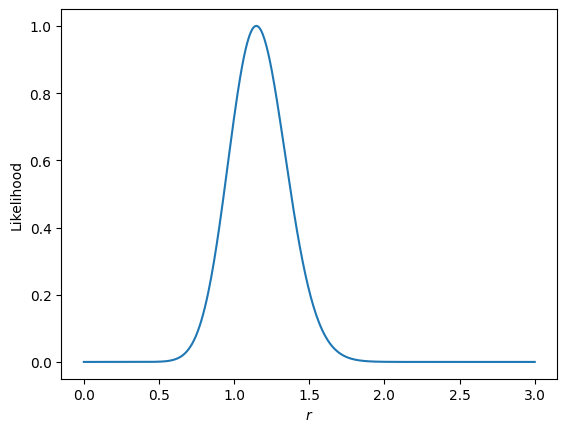

In [39]:
plt.plot(loglike[0], np.exp(loglike[1]-loglike[1].max()))
plt.ylabel('Likelihood')
plt.xlabel(r'$r$')

We can see that we recover something pretty close to 1, our input $r$ value for the example. If we ran this for many signal+noise sims, we should get precisely 1 in the average. 

If you instead are using mcmc=True, the likelihoods file written to disk will have a field called "samples". Histogramming that up, or using a program like `getdist`, especially helpful for multiple parameters, will give you the posteriors for your various parameters.

The likelihoods function sets the CMB qb values to 1 and all others (esp., residuals) to their maximum likelihood values. To instead include these parameters in your fit, you set the `prior` arguments. So:

* `r_prior`: set to [0, 'inf'] to inclue $r$ in the fit (or ['-inf', 'inf'] to impose no physical prior)
* `alpha_prior`: same as `r_prior`-- set to None to not fit for alpha template scalings.
* `res_prior`: same as previous-- will vary all $n_b$ parameters as part of the model
* `beam_prior`: this is different! To account for beam uncertainty, set this to [0, 1], where the first parameter is the Gaussian mean, and the second is the number of standard deviations to use as the width. Here, you must have set the `beam_error_product` in your config file to a dictionary containing the one-sigma error on the beam shape per ell, and then that envelope is varied according to a Gaussian with each step to marginalize over the beam uncertainty.

That wraps up the example!